In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import h5py
import numpy as np
import pandas as pd
import re
import os
import sys

import mouse1d_analysis as m1da

sys.path.append("/../../HALnalysis")
import analysis_package.maxlab_analysis as mla

import analysis_package.burst as burst
from analysis_package.burst import Burst

import regex as re

plt.switch_backend("Qt5Agg")

In [7]:
#Get bursts from raw data
homedir=os.path.expanduser("~")

#filepath = "/run/user/1001/gvfs/smb-share:server=rstore.it.tufts.edu,share=as_rsch_levinlab_wclawson01$/Experimental Data/Summer 2024/mouse_1d/7-9 mouse_1d_test/7/well4/"
#filepath = "/run/user/1001/gvfs/smb-share:server=rstore.it.tufts.edu,share=as_rsch_levinlab_wclawson01$/Experimental Data/Summer 2024/mouse_1d/2h_7-12/M07484/240712/4/well4/"
#filepath = "/run/user/1001/gvfs/smb-share:server=rstore.it.tufts.edu,share=as_rsch_levinlab_wclawson01$/Experimental Data/Summer 2024/mouse_1d/DIV13/M07475/240716/0/well1/"
#filepath = "/run/user/1001/gvfs/smb-share:server=rstore.it.tufts.edu,share=as_rsch_levinlab_wclawson01$/Experimental Data/Summer 2024/mouse_1d/DIV13_no_media_change/M07472/240716/1/well0/"
#filepath = "/run/user/1001/gvfs/smb-share:server=rstore.it.tufts.edu,share=as_rsch_levinlab_wclawson01$/Experimental Data/Summer 2024/mouse_1d/DIV15_mouse1d/M07475/240718/3/well1/"
#filepath = "/run/user/1001/gvfs/smb-share:server=rstore.it.tufts.edu,share=as_rsch_levinlab_wclawson01$/Experimental Data/Summer 2024/mouse_1d/mouse1d_direction_test/M07472/240719/8/well4/"
#filepath = "/run/user/1001/gvfs/smb-share:server=rstore.it.tufts.edu,share=as_rsch_levinlab_wclawson01$/Experimental Data/Summer 2024/mouse_1d/DIV16_mouse1d_no_media_change/M07472/240719/0/well0/"
filepath = "/run/user/1000/gvfs/smb-share:server=rstoreint.it.tufts.edu,share=as_rsch_levinlab_wclawson01$/Experimental Data/Summer 2024/mouse_1d/DIV16_mouse1d/M07475/240719/2/well4/"

#filename = "DIV15_mouse1d_well_1"
#filename = "DIV13_no_media_change_well_0"
filename = "DIV16_mouse1d_well_4"
filetag = ".raw.h5"
datapath = homedir + "/Documents/HALnalysis/mouse1d_analysis/processed_data/"
well_no = 4
recording_no = 0

In [8]:
mapping = mla.load_mapping(filepath + filename + filetag, well_no, recording_no)

In [9]:
mapping.loc[mapping["electrode"] == 19617]

channel  electrode      x       y
186      186      19617  647.5  1557.5

In [5]:
events = mla.load_spikes_from_file(filepath + filename + filetag, well_no = well_no)
display(events)

time  channel  amplitude
0           -0.2283      880  -6.226667
1           -0.2228      431  -3.973392
2           -0.2226      289  -5.984657
3           -0.2118      741  -3.934168
4           -0.2109      768  -3.461889
...             ...      ...        ...
25798186  3605.0019       40  -6.913296
25798187  3605.0092       40   6.786106
25798188  3604.8416      110  -5.356091
25798189  3604.8460      790  -3.253943
25798190  3604.8483        2  -8.125424

[25798191 rows x 3 columns]

In [13]:
plt.scatter(events.loc[events["channel"] == 186, "time"], events.loc[events["channel"] == 186, "amplitude"])
plt.show()

KeyboardInterrupt: 

In [ ]:
events = mla.load_events(filepath + filename + filetag, well_no)
display(events)

In [223]:
pre_train_movement_df = pd.DataFrame(columns = ["frameno", "time", "position"])
train_movement_df = pd.DataFrame(columns = ["frameno", "time", "position"])
movement_df = pd.DataFrame(columns = ["frameno", "time", "position"])
full_movement_df = pd.DataFrame(columns = ["frameno", "time", "position"])


current_pos = -1
world = None

for i in events.index:
    
    message = events.loc[i, "eventmessage_decoded"]
    if "moveto" in message:
        numbers = [int(num) for num in re.findall(r'\d+', message)]
        if not world:
            world = list(str(numbers[0]))
        new_pos = numbers[1]
        
        if new_pos != current_pos:
            movement_df.loc[len(movement_df), :] = [events.loc[i, "frameno_adjusted"], events.loc[i, "time"], new_pos]
            full_movement_df.loc[len(full_movement_df), :] = [events.loc[i, "frameno_adjusted"], events.loc[i, "time"], new_pos]
            current_pos = new_pos
    elif message == "{\"training\":\"1\"}\n":
        train_time = events.loc[i, "time"]
        print("switch to train at time " + str(train_time))
        pre_train_movement_df = movement_df
        movement_df = pd.DataFrame(columns = ["frameno", "time", "position"])


train_movement_df = movement_df
full_movement_df



switch to train at time 1805.0415


frameno       time position
0       50522     5.0522        3
1      380145    38.0145        2
2      394602    39.4602        1
3      816293    81.6293        2
4     1420113   142.0113        1
..        ...        ...      ...
105  34735147  3473.5147        0
106  35077544  3507.7544        3
107  35098841  3509.8841        2
108  35502413  3550.2413        3
109  36012133  3601.2133        0

[110 rows x 3 columns]

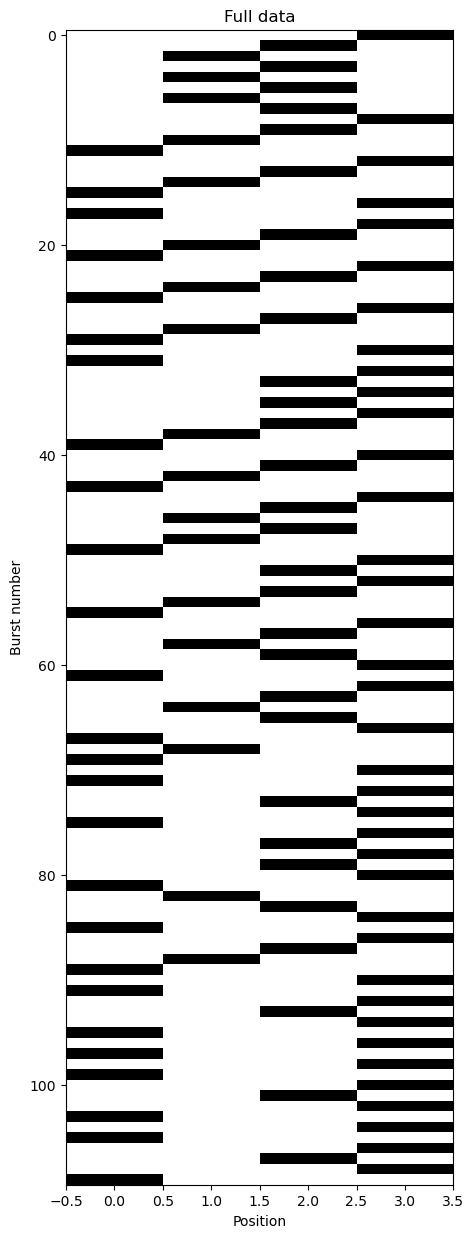

In [224]:
xtplot = np.zeros((len(full_movement_df), 1 + max(full_movement_df["position"])))
for i in full_movement_df.index:
    xtplot[i, full_movement_df.loc[i, "position"]] = 1

plt.figure(figsize = (5, 15))
plt.imshow(xtplot, aspect = "auto", interpolation = "none", cmap = "Greys")
plt.title("Full data")
plt.ylabel("Burst number")
plt.xlabel("Position")
plt.show()
#plt.close()

xtplot = np.zeros((len(pre_train_movement_df), 1 + max(pre_train_movement_df["position"])))
for i in pre_train_movement_df.index:
    xtplot[i, pre_train_movement_df.loc[i, "position"]] = 1

plt.figure(figsize = (5, 10))
plt.imshow(xtplot, aspect = "auto", interpolation = "none", cmap = "Greys")
plt.title("No stim")
plt.ylabel("Burst number")
plt.xlabel("Position")
#plt.show()
plt.close()


xtplot = np.zeros((len(train_movement_df), 1 + max(train_movement_df["position"])))
for i in train_movement_df.index:
    xtplot[i, train_movement_df.loc[i, "position"]] = 1

plt.figure(figsize = (5, 10))
plt.imshow(xtplot, aspect = "auto", interpolation = "none", cmap = "Greys")
plt.title("Stim")
plt.ylabel("Burst number")
plt.xlabel("Position")
#plt.show()
plt.close()


In [225]:

midway = (min(train_movement_df["frameno"]) + max(train_movement_df["frameno"]))/2

first_half_train_movement_df = train_movement_df.loc[train_movement_df["frameno"] < midway, :].reset_index()
second_half_train_movement_df = train_movement_df.loc[train_movement_df["frameno"] > midway, :].reset_index()

midway = (min(pre_train_movement_df["frameno"]) + max(pre_train_movement_df["frameno"]))/2

first_half_pre_train_movement_df = pre_train_movement_df.loc[pre_train_movement_df["frameno"] < midway, :].reset_index()
second_half_pre_train_movement_df = pre_train_movement_df.loc[pre_train_movement_df["frameno"] > midway, :].reset_index()

In [226]:
train_transition_df = m1da.build_transition_df(train_movement_df, world)
pre_train_transition_df = m1da.build_transition_df(pre_train_movement_df, world)
first_half_train_transition_df = m1da.build_transition_df(first_half_train_movement_df, world)
second_half_train_transition_df = m1da.build_transition_df(second_half_train_movement_df, world)

first_half_pre_train_transition_df = m1da.build_transition_df(first_half_pre_train_movement_df, world)
second_half_pre_train_transition_df = m1da.build_transition_df(second_half_pre_train_movement_df, world)

train_transition_df

leftward  rightward  total  proportion left object
0      12.0        2.0   14.0         0.857143      1
1       2.0        3.0    5.0         0.400000      0
2       3.0        9.0   12.0         0.250000      0
3       8.0       13.0   21.0         0.380952      0

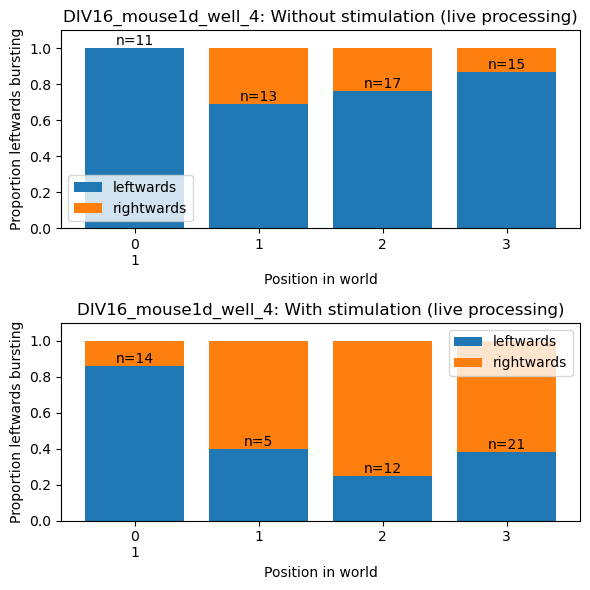

In [227]:
plt.figure(figsize = (6, 6))
ax = plt.subplot(212)
plt.title(filename + ": With stimulation (live processing)")
m1da.make_probability_bars(train_transition_df, world)

ax = plt.subplot(211)
plt.title(filename + ": Without stimulation (live processing)")
m1da.make_probability_bars(pre_train_transition_df, world)

plt.tight_layout()

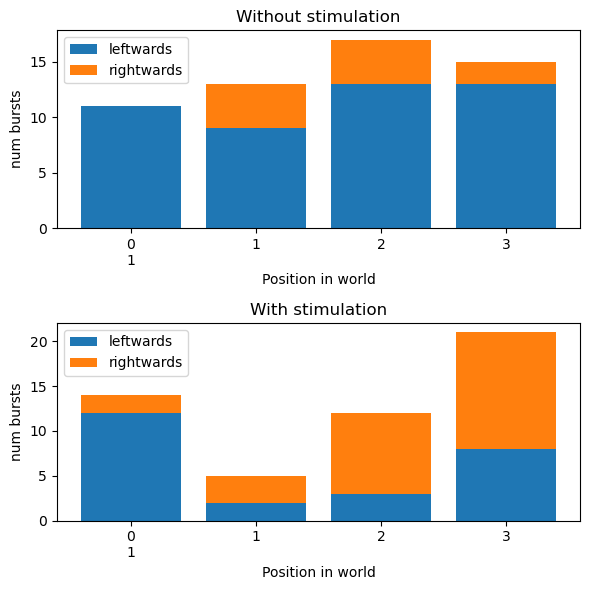

In [228]:
plt.figure(figsize = (6, 6))
ax = plt.subplot(212)
plt.title("With stimulation")
m1da.make_count_bars(train_transition_df, world)

ax = plt.subplot(211)
plt.title("Without stimulation")
m1da.make_count_bars(pre_train_transition_df, world)

plt.tight_layout()
plt.show()

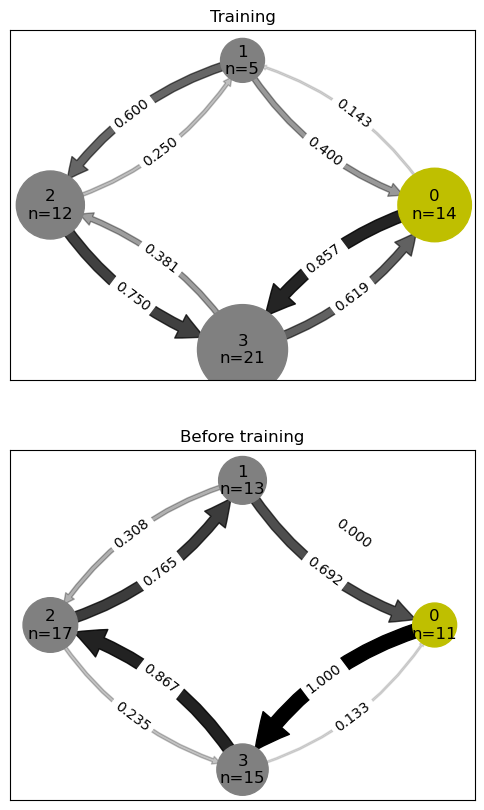

In [229]:
plt.figure(figsize = (6, 10))
plt.subplot(211)
plt.title("Training")
m1da.make_network_graph(train_transition_df, world)
plt.subplot(212)
plt.title("Before training")
m1da.make_network_graph(pre_train_transition_df, world)

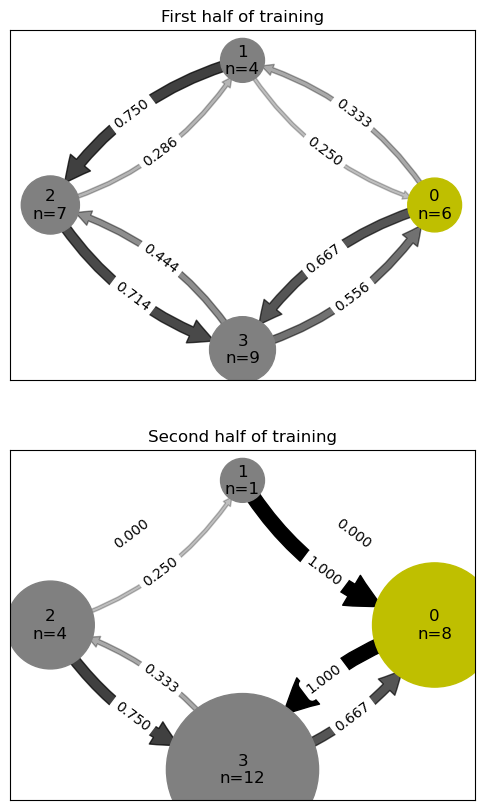

In [230]:
plt.figure(figsize = (6, 10))
plt.subplot(211)
plt.title("First half of training")
m1da.make_network_graph(first_half_train_transition_df, world)
plt.subplot(212)
plt.title("Second half of training")
m1da.make_network_graph(second_half_train_transition_df, world)

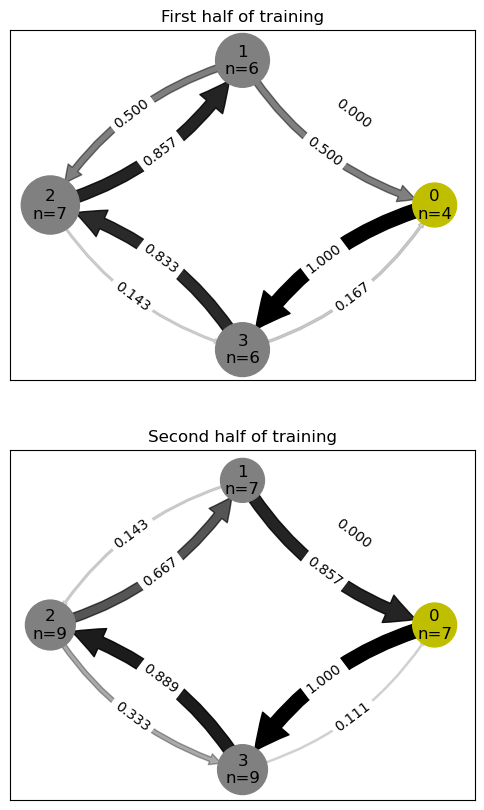

In [231]:
plt.figure(figsize = (6, 10))
plt.subplot(211)
plt.title("First half of training")
m1da.make_network_graph(first_half_pre_train_transition_df, world)
plt.subplot(212)
plt.title("Second half of training")
m1da.make_network_graph(second_half_pre_train_transition_df, world)

# Process the real data and get burst direction probabilities

In [232]:
display( train_movement_df)
display(pre_train_movement_df)
display(full_movement_df)

frameno       time position
0   18220577  1822.0577        2
1   18624020   1862.402        1
2   18963860   1896.386        2
3   19452368  1945.2368        3
4   19919746  1991.9746        0
5   20347078  2034.7078        3
6   20633717  2063.3717        2
7   20941763  2094.1763        1
8   21302769  2130.2769        2
9   21685039  2168.5039        3
10  22120552  2212.0552        0
11  22452307  2245.2307        1
12  22473514  2247.3514        0
13  22837115  2283.7115        3
14  23261941  2326.1941        0
15  23572344  2357.2344        3
16  23593551  2359.3551        2
17  24050217  2405.0217        3
18  24443195  2444.3195        0
19  24700609  2470.0609        3
20  24721817  2472.1817        2
21  25135981  2513.5981        3
22  25539564  2553.9564        2
23  25964315  2596.4315        3
24  26208612  2620.8612        0
25  26497899  2649.7899        1
26  26869477  2686.9477        2
27  27368734  2736.8734        3
28  27782793  2778.2793        0
29  28231393  2823.1393        3
30  28252674  2825.2674        2
31  28581916  2858.1916        1
32  29059784  2905.9784        0
33  29423297  2942.3297        3
34  29784376  2978.4376        0
35  30148086  3014.8086        3
36  30169293  3016.9293        2
37  30519782  3051.9782        3
38  30891366  3089.1366        0
39  31562937  3156.2937        3
40  31913486  3191.3486        0
41  32425761  3242.5761        3
42  32776128  3277.6128        0
43  33107903  3310.7903        3
44  33129111  3312.9111        2
45  33617641  3361.7641        3
46  34042402  3404.2402        0
47  34352884  3435.2884        3
48  34735147  3473.5147        0
49  35077544  3507.7544        3
50  35098841  3509.8841        2
51  35502413  3550.2413        3
52  36012133  3601.2133        0

frameno       time position
0      50522     5.0522        3
1     380145    38.0145        2
2     394602    39.4602        1
3     816293    81.6293        2
4    1420113   142.0113        1
5    2004590    200.459        2
6    2491433   249.1433        1
7    2780482   278.0482        2
8    3300655   330.0655        3
9    3663667   366.3667        2
10   4380421   438.0421        1
11   4806945   480.6945        0
12   5229053   522.9053        3
13   5731544   573.1544        2
14   6113446   611.3446        1
15   6569714   656.9714        0
16   6581387   658.1387        3
17   7153808   715.3808        0
18   7645875   764.5875        3
19   8117813   811.7813        2
20   8129871   812.9871        1
21   8445842   844.5842        0
22   8457911   845.7911        3
23   8918187   891.8187        2
24   9238216   923.8216        1
25   9250235   925.0235        0
26   9594353   959.4353        3
27  10182479  1018.2479        2
28  10642753  1064.2753        1
29  11053236  1105.3236        0
30  11358763  1135.8763        3
31  11870857  1187.0857        0
32  12235072  1223.5072        3
33  12247131  1224.7131        2
34  12518116  1251.8116        3
35  12530986  1253.0986        2
36  13039114  1303.9114        3
37  13349427  1334.9427        2
38  13362303  1336.2303        1
39  13677893  1367.7893        0
40  13690761  1369.0761        3
41  14078652  1407.8652        2
42  14475454  1447.5454        1
43  14859718  1485.9718        0
44  15163648  1516.3648        3
45  15175725  1517.5725        2
46  15187765  1518.7765        1
47  15550786  1555.0786        2
48  15922241  1592.2241        1
49  16319846  1631.9846        0
50  16648242  1664.8242        3
51  16659911  1665.9911        2
52  16964246  1696.4246        3
53  16976272  1697.6272        2
54  17440193  1744.0193        1
55  17452244  1745.2244        0
56  17872334  1787.2334        3

frameno       time position
0       50522     5.0522        3
1      380145    38.0145        2
2      394602    39.4602        1
3      816293    81.6293        2
4     1420113   142.0113        1
..        ...        ...      ...
105  34735147  3473.5147        0
106  35077544  3507.7544        3
107  35098841  3509.8841        2
108  35502413  3550.2413        3
109  36012133  3601.2133        0

[110 rows x 3 columns]

['events', 'groups', 'recording_id', 'settings', 'spikes', 'start_time', 'stop_time', 'well_id']


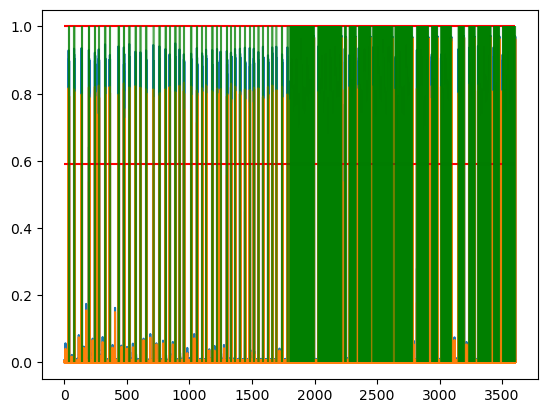

burst found in bin 3364 (time 33.41 s)
burst found in bin 3458 (time 34.35 s)
burst found in bin 3557 (time 35.34 s)
burst found in bin 3665 (time 36.42 s)
burst found in bin 3797 (time 37.74 s)
burst found in bin 7729 (time 77.06 s)
burst found in bin 7823 (time 78.00 s)
burst found in bin 7919 (time 78.96 s)
burst found in bin 8026 (time 80.03 s)
burst found in bin 8150 (time 81.27 s)
burst found in bin 13699 (time 136.76 s)
burst found in bin 13783 (time 137.60 s)
burst found in bin 13860 (time 138.37 s)
burst found in bin 13953 (time 139.30 s)
burst found in bin 14054 (time 140.31 s)
burst found in bin 19561 (time 195.38 s)
burst found in bin 19646 (time 196.23 s)
burst found in bin 19721 (time 196.98 s)
burst found in bin 19812 (time 197.89 s)
burst found in bin 19913 (time 198.90 s)
burst found in bin 20031 (time 200.08 s)
burst found in bin 24367 (time 243.44 s)
burst found in bin 24461 (time 244.38 s)
burst found in bin 24550 (time 245.27 s)
burst found in bin 24651 (time 246.2

In [233]:
burst_list = burst.find_bursts(filepath, filename, well_no, recording_no, burst_thresh = 5, datapath = datapath, stim_thresh = 1) # don't filter out stimulations by burst size - do it with events.
print(len(burst_list))

In [234]:
p = re.compile(r"stimulation\":\"\L<world_locs>\"", world_locs=set(world))

#this intermediate step isn't actually necessary
stimulation_events = events.loc[["stimulation" in i for i in events["eventmessage_decoded"]], :]
# for i in stimulation_events["eventmessage_decoded"]:
#     print(i)


big_stimulation_events = stimulation_events.loc[[not (p.search(i) is None) for i in stimulation_events["eventmessage_decoded"]], :]
big_stimulation_events.head()

frameno  eventtype  eventid  \
768   187668678          1      178   
769   187724256          1      179   
1549  189869484          1      178   
1550  189925062          1      179   
1639  190222447          1      178   

                                           eventmessage  frameno_adjusted  \
768   b'{"amp_mV":"200","dac":"2","num_trains":"5","...          19919796   
769   b'{"amp_mV":"200","dac":"2","end_stimulation":...          19975374   
1549  b'{"amp_mV":"200","dac":"2","num_trains":"5","...          22120602   
1550  b'{"amp_mV":"200","dac":"2","end_stimulation":...          22176180   
1639  b'{"amp_mV":"200","dac":"2","num_trains":"5","...          22473565   

           time                               eventmessage_decoded  
768   1991.9796  {"amp_mV":"200","dac":"2","num_trains":"5","ph...  
769   1997.5374  {"amp_mV":"200","dac":"2","end_stimulation":"1...  
1549  2212.0602  {"amp_mV":"200","dac":"2","num_trains":"5","ph...  
1550  2217.6180  {"amp_mV":"200","dac":"2","end_stimulation":"1...  
1639  2247.3565  {"amp_mV":"200","dac":"2","num_trains":"5","ph...

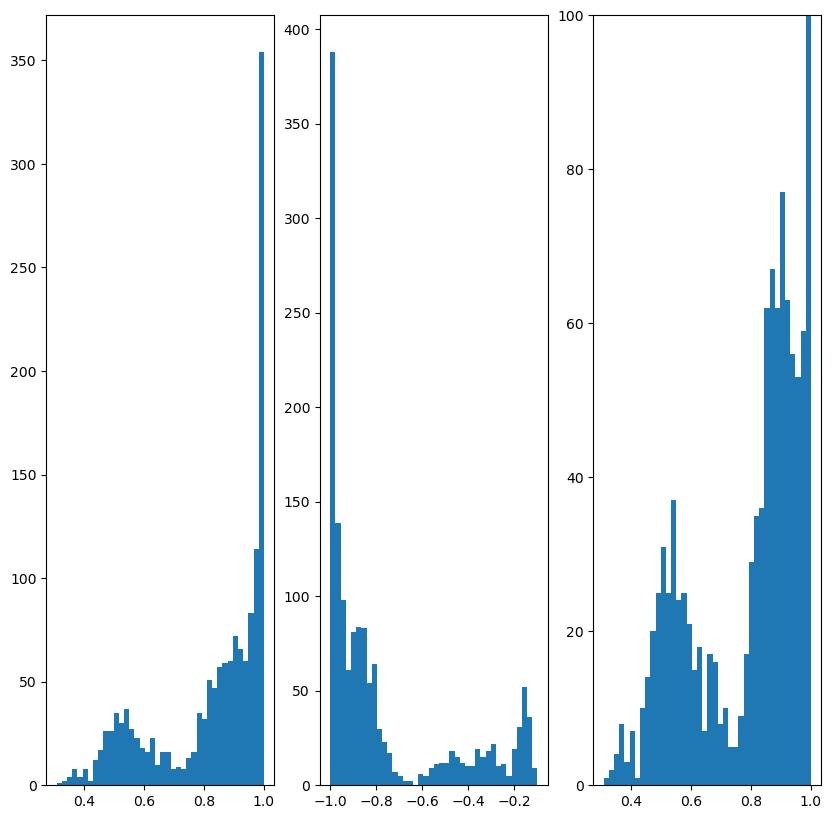

(-1.0, 0.0)

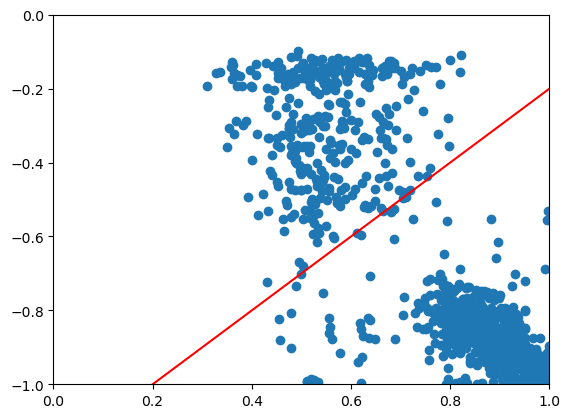

In [235]:
onset_list = list()
offset_list = list()
maxes = list()

const = -0.2

for i in burst_list:
    i.
    onset_frac = i.calculate_onset_offset(1)[1]/i.max_height()
    offset_frac = i.calculate_onset_offset(1)[0]/i.max_height()
    max_val = max(onset_frac, -offset_frac)
    #if 0.61 > max_val > 0.5:
    #   i.plot()
    #   print(i.calculate_onset_offset())
    #   print(onset_frac)
    #   print(offset_frac)
    onset_list.append(onset_frac)
    offset_list.append(offset_frac)
    maxes.append(max(onset_frac, -offset_frac))

plt.figure(figsize = (10, 10))
plt.subplot(131)
plt.hist(onset_list, 40)
plt.subplot(132)
plt.hist(offset_list, 40)
plt.subplot(133)
plt.hist(maxes, 40)
plt.ylim(0, 100)
plt.show()
#plt.plot(offset_list)
#plt.plot()
plt.figure()
plt.scatter(onset_list, offset_list)
x = np.arange(-1, 2, 0.1)
y = x - 1 + const
plt.plot(x, y, "r")
plt.xlim(0, 1)
plt.ylim(-1, 0)

In [236]:
trimmed_burst_list = list()
thresh = 0.75

#First remove the stims that we know we don't care about.
for i, burst in enumerate(burst_list):
    time = burst.time
    sub_big_stimulation_events = big_stimulation_events.loc[big_stimulation_events["time"] < time + 0.5].reset_index(drop = True)
    if len(sub_big_stimulation_events) > 0 and "start_stimulation" in sub_big_stimulation_events.loc[len(sub_big_stimulation_events) - 1, "eventmessage_decoded"]:
        #print(sub_big_stimulation_events.loc[len(sub_big_stimulation_events) - 1, :])
        print("removing burst at time " + str(time))
    else:
        trimmed_burst_list.append(burst)

print("Secondary burst removal:")
second_trimmed_burst_list= list()
for i, burst in enumerate(trimmed_burst_list):
    onset_frac = burst.calculate_onset_offset()[1]/burst.max_height()
    offset_frac = burst.calculate_onset_offset()[0]/burst.max_height()
    max_val = max(onset_frac, -offset_frac)
    time = burst.time
    #if max_val > thresh:
    #    print("removing burst at time " + str(time))
    
    if onset_frac - offset_frac > (1 - const):
        print("removing burst at time " + str(time))
    else:
        second_trimmed_burst_list.append(burst)

print(len(second_trimmed_burst_list))

print("Tertiary burst removal:")
for i in range(len(second_trimmed_burst_list) - 1, 0, -1):
    if second_trimmed_burst_list[i].time - 3 < second_trimmed_burst_list[i-1].time:
        second_trimmed_burst_list.pop(i)

print(len(second_trimmed_burst_list))

removing burst at time 1991.5700000000018
removing burst at time 1992.6600000000017
removing burst at time 1993.7700000000018
removing burst at time 1994.9300000000017
removing burst at time 1996.0300000000018
removing burst at time 2211.640000000002
removing burst at time 2212.740000000002
removing burst at time 2213.8500000000017
removing burst at time 2215.000000000002
removing burst at time 2216.110000000002
removing burst at time 2246.960000000002
removing burst at time 2248.070000000002
removing burst at time 2249.170000000002
removing burst at time 2250.270000000002
removing burst at time 2251.370000000002
removing burst at time 2325.7900000000022
removing burst at time 2326.890000000002
removing burst at time 2327.990000000002
removing burst at time 2329.150000000002
removing burst at time 2330.2500000000023
removing burst at time 2443.880000000002
removing burst at time 2445.0400000000022
removing burst at time 2446.140000000002
removing burst at time 2447.2300000000023
removi

In [237]:
print([i.time for i in second_trimmed_burst_list])
for i in list(second_trimmed_burst_list)[-20:0]:
    i.plot()
    print(i.burst_direction(0.1))

[33.41000000000003, 77.06000000000006, 136.76000000000013, 195.3800000000002, 243.44000000000023, 274.1400000000002, 324.73000000000025, 361.5000000000003, 431.98000000000036, 474.9300000000004, 518.3600000000005, 567.5900000000005, 606.7100000000005, 652.7200000000006, 710.2200000000006, 759.3100000000006, 807.6700000000008, 840.9400000000007, 886.1800000000007, 920.0800000000008, 954.7300000000008, 1013.3600000000009, 1058.8500000000008, 1100.690000000001, 1132.290000000001, 1181.700000000001, 1220.080000000001, 1247.9300000000012, 1298.5100000000011, 1331.1200000000013, 1364.9800000000012, 1403.2000000000012, 1443.0800000000013, 1481.4600000000014, 1513.8700000000013, 1551.2200000000014, 1587.3600000000015, 1627.6500000000015, 1661.2800000000016, 1693.9200000000014, 1739.9600000000016, 1782.8400000000015, 1815.5600000000015, 1856.1200000000017, 1890.6300000000017, 1938.0200000000018, 1986.6400000000017, 2029.3800000000017, 2058.110000000002, 2087.760000000002, 2124.280000000002, 216

building xt plot


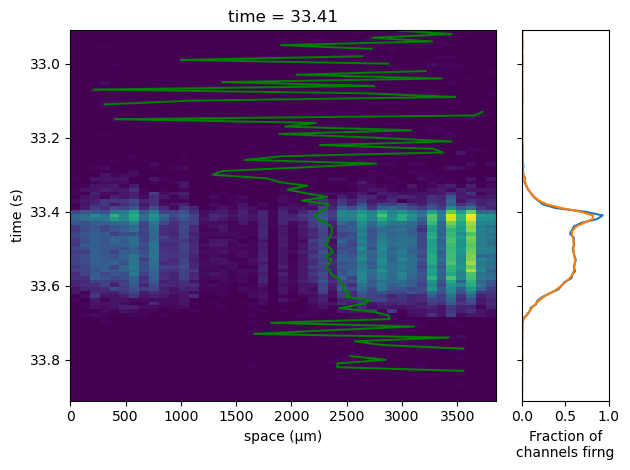

82.31769090590842
building xt plot


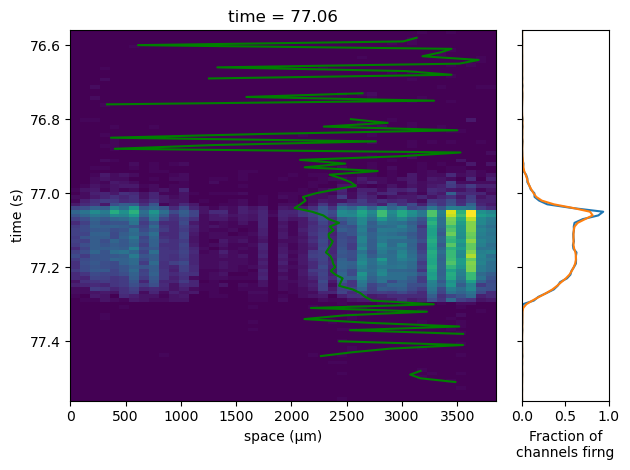

-103.8203934772564
building xt plot


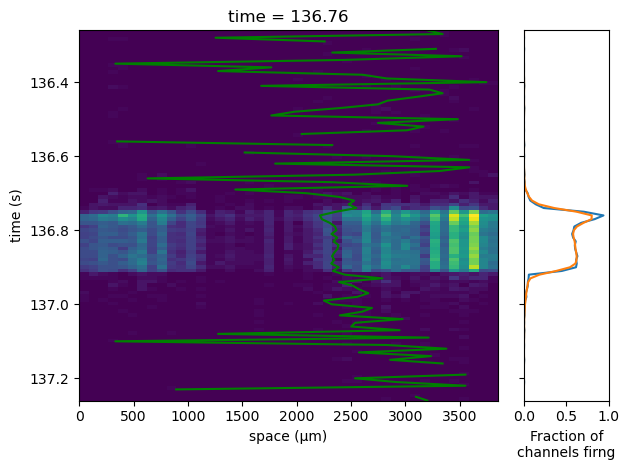

-263.78767022451257
building xt plot


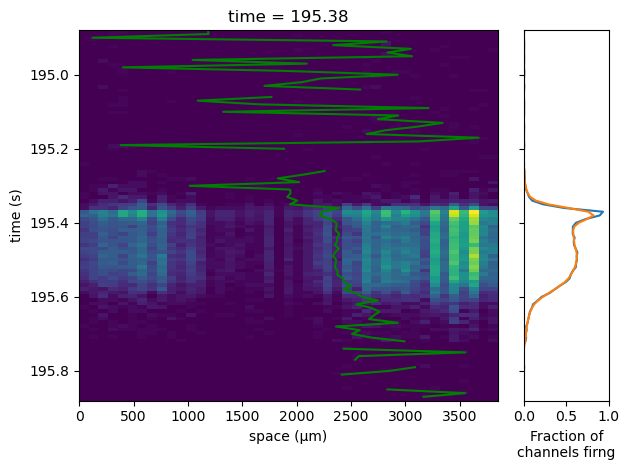

205.17649006622514
building xt plot


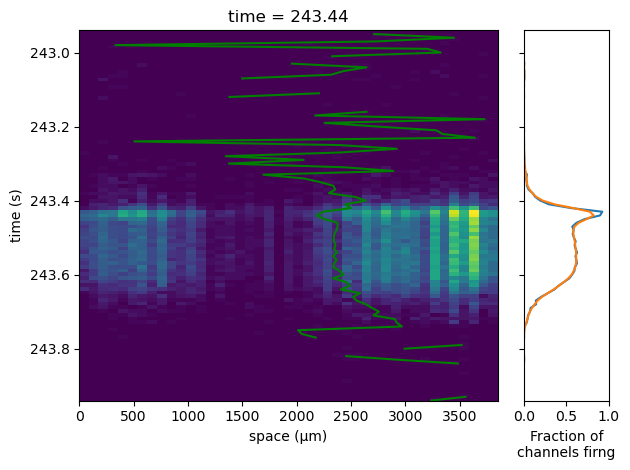

-111.18151815181545
building xt plot


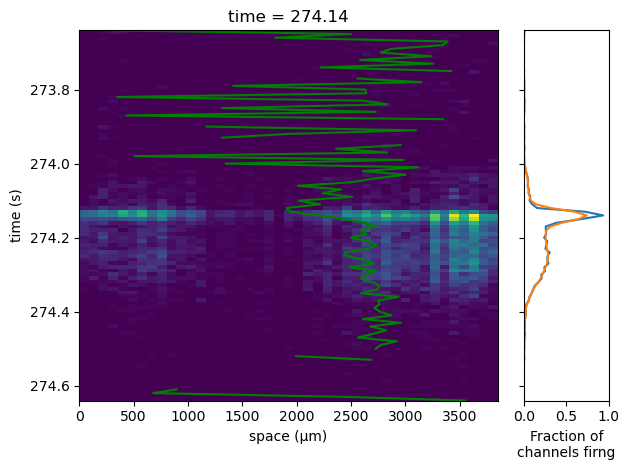

7.088575136583586
building xt plot


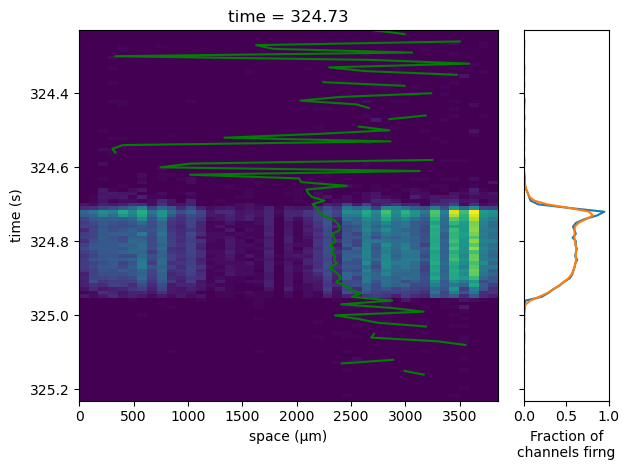

-15.905821917808225
building xt plot


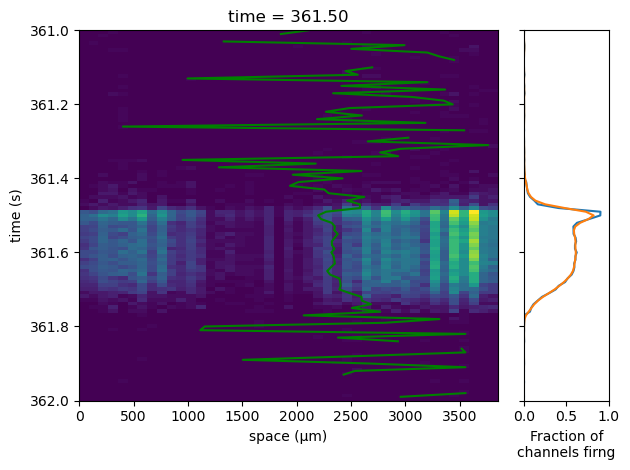

-267.18355263157855
building xt plot


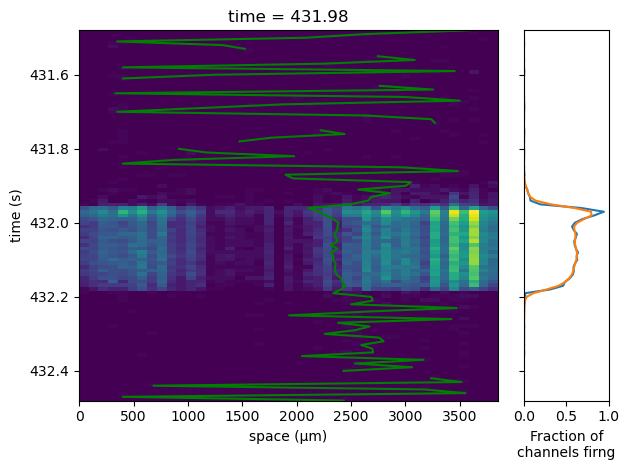

-391.77994636471976
building xt plot


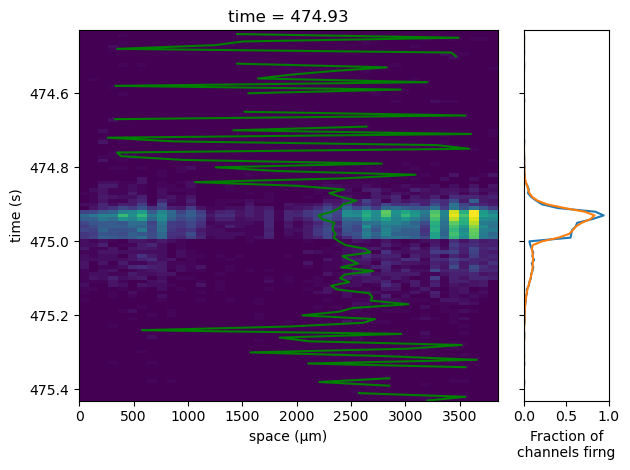

-348.00770308123265
building xt plot


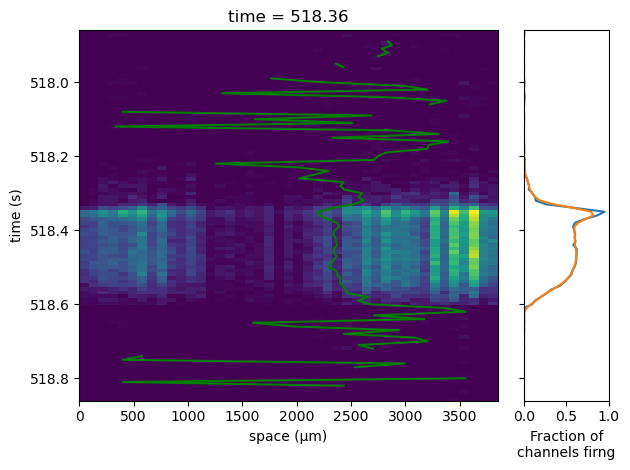

-356.88025714972355
building xt plot


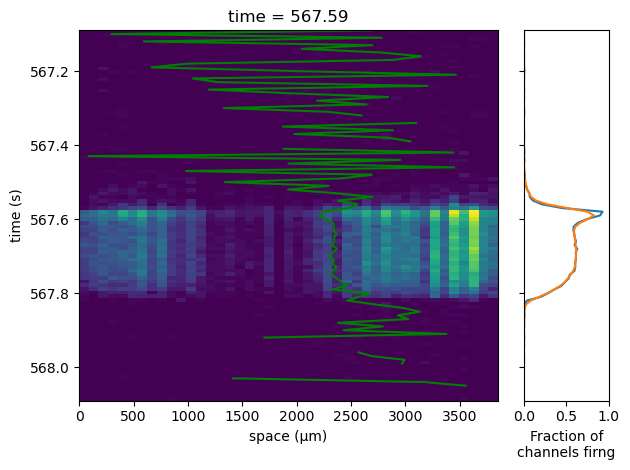

-174.60489510489515
building xt plot


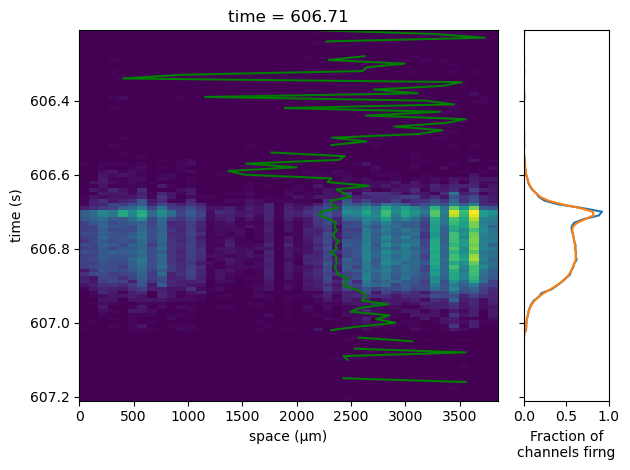

-157.6687208431722
building xt plot


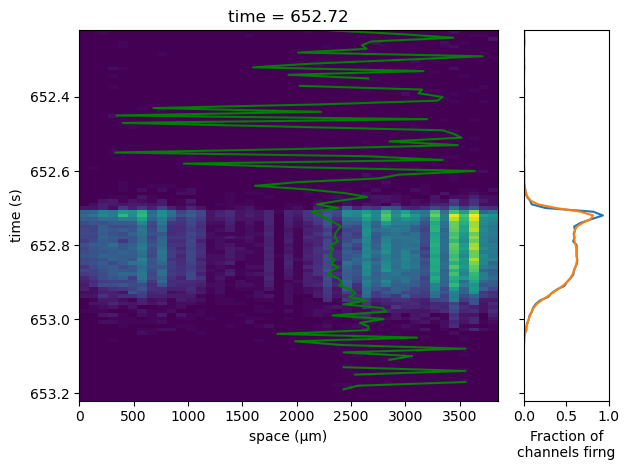

27.731267345051037
building xt plot


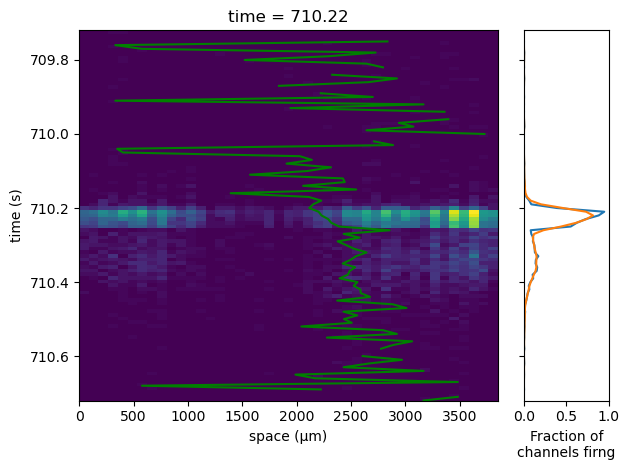

77.05751349446973
building xt plot


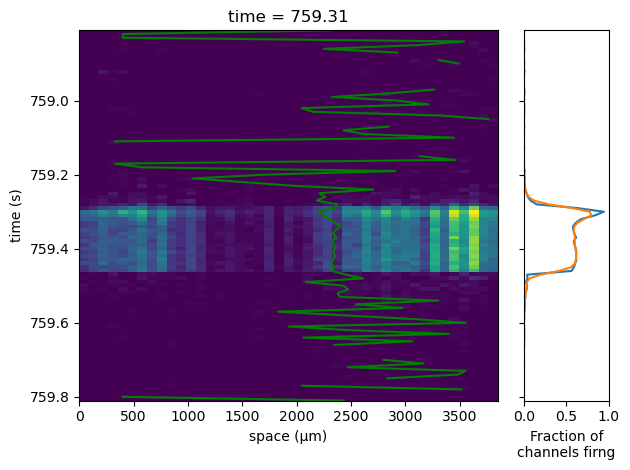

68.96675531914889
building xt plot


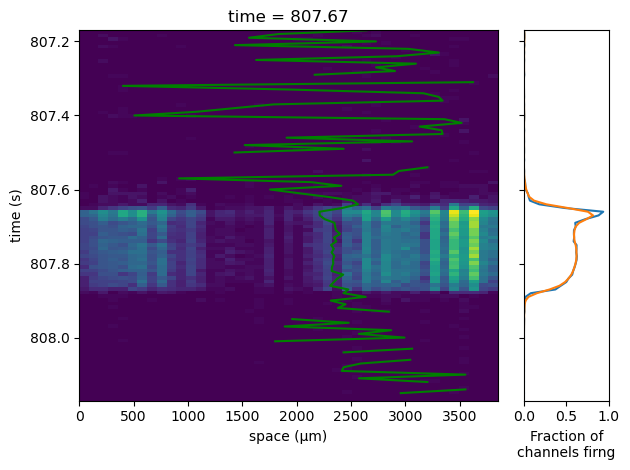

-304.89599188229295
building xt plot


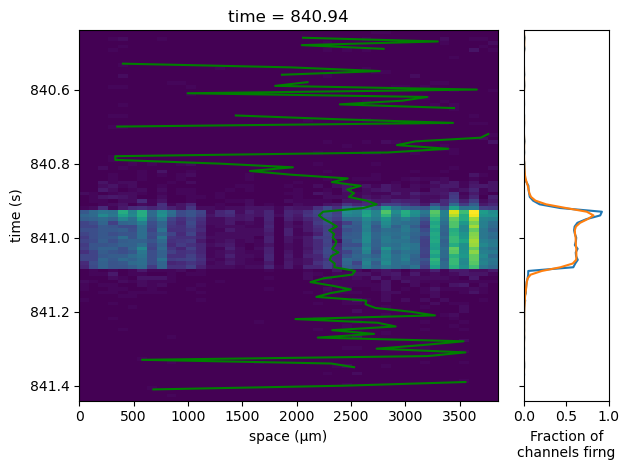

-436.9596846622094
building xt plot


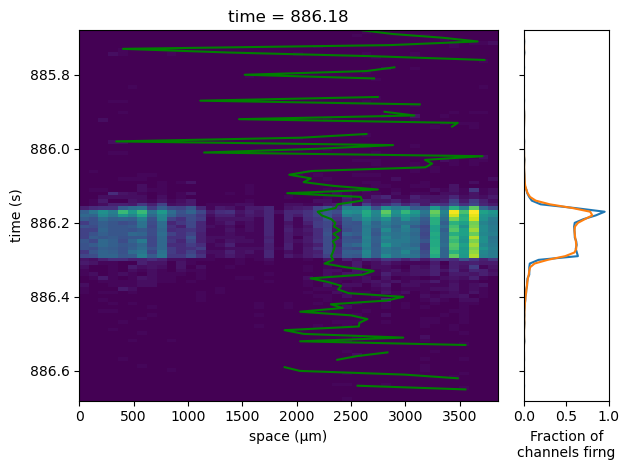

-371.92083768347356
building xt plot


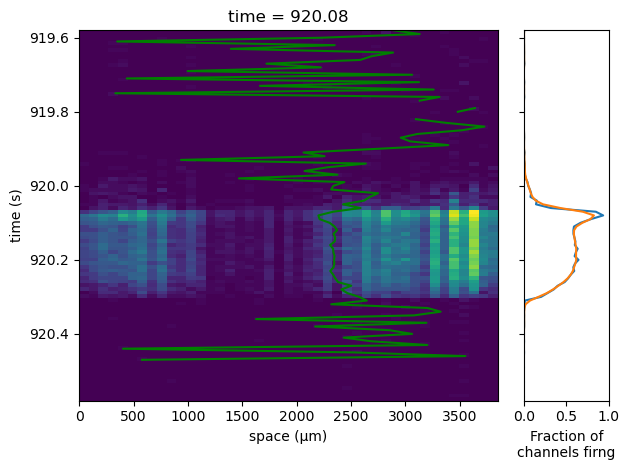

-472.9154066422243
building xt plot


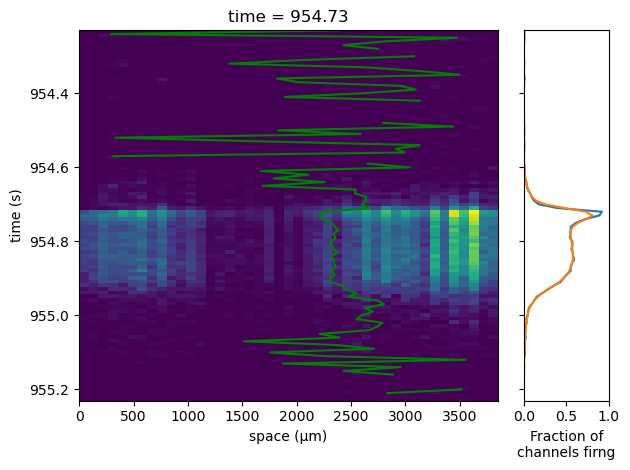

-437.10798187199407
building xt plot


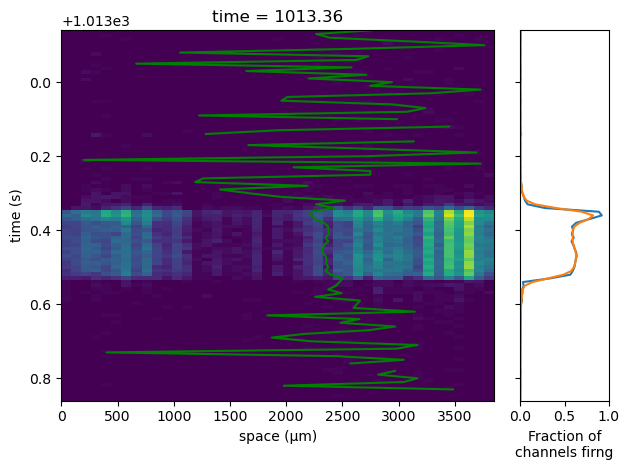

-43.27974276527311
building xt plot


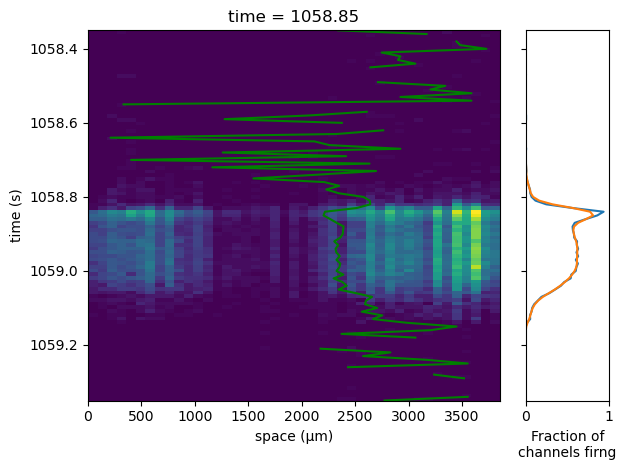

-433.1189862542956
building xt plot


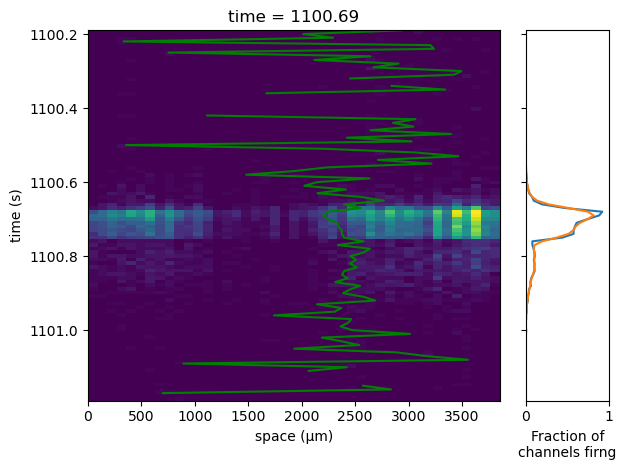

-566.317471590909
building xt plot


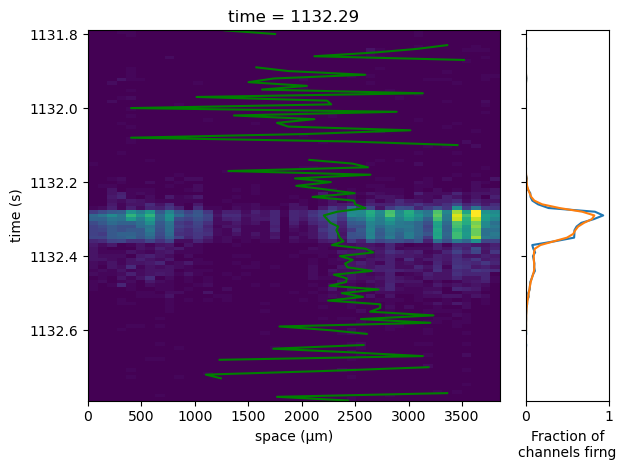

-282.78590785907863
building xt plot


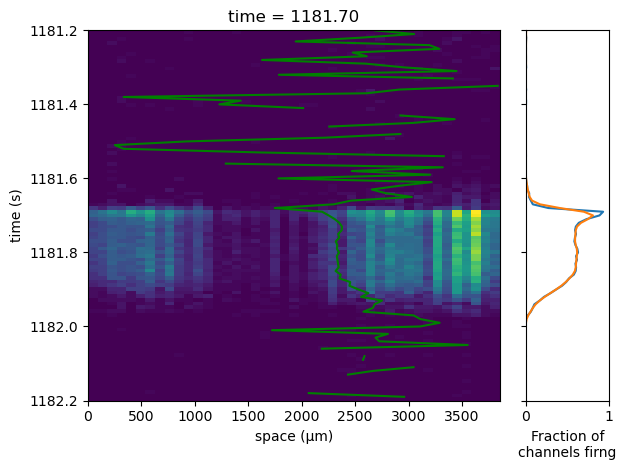

-46.5181818181818
building xt plot


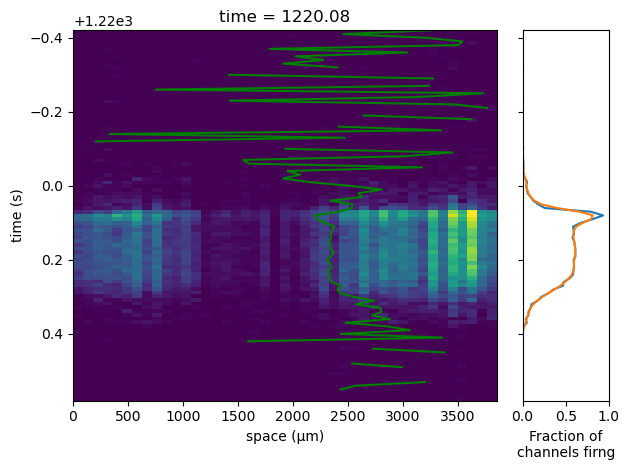

-142.6510618326879
building xt plot


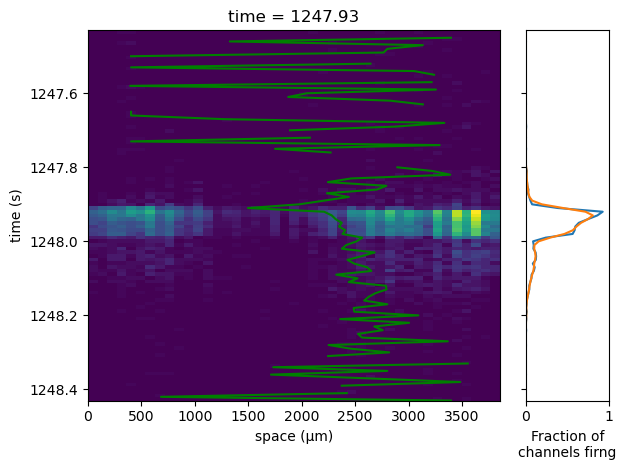

302.1402398401067
building xt plot


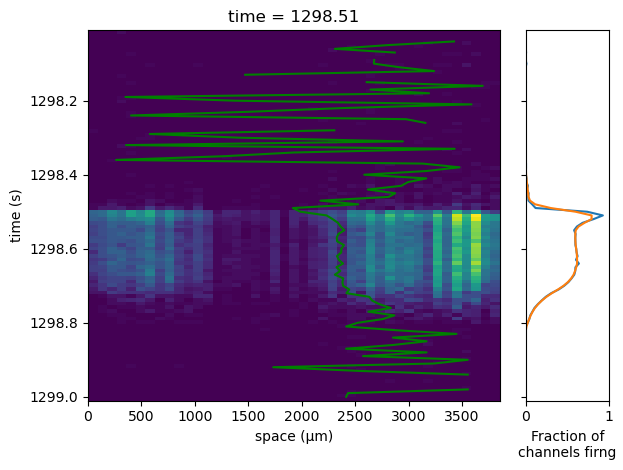

-296.2623538788521
building xt plot


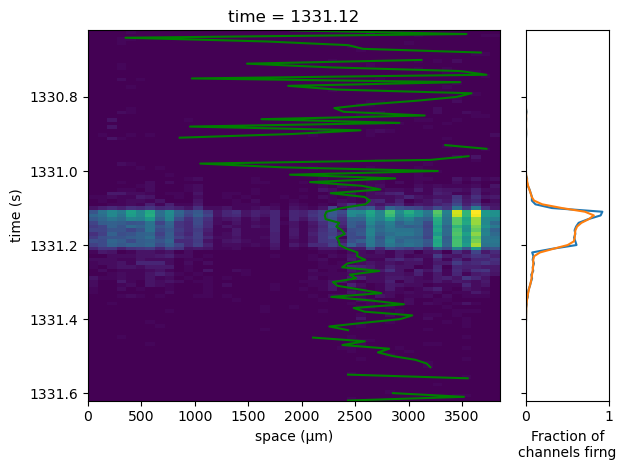

-422.74703443510316
building xt plot


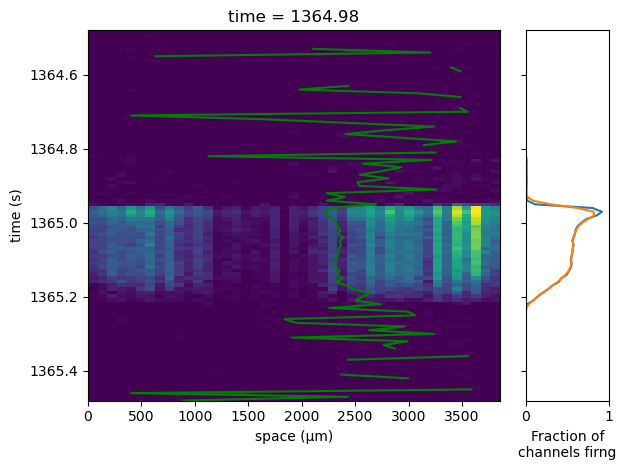

-458.96488423047276
building xt plot


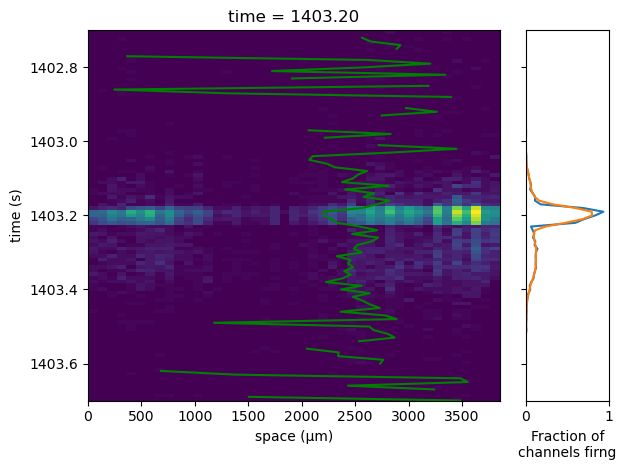

-371.2325448845827
building xt plot


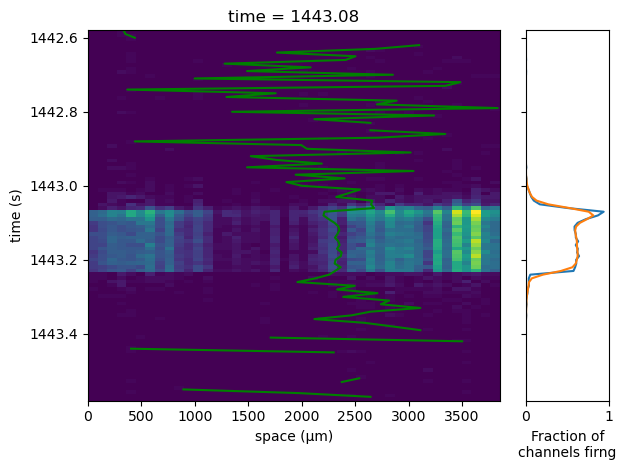

-457.32406356413185
building xt plot


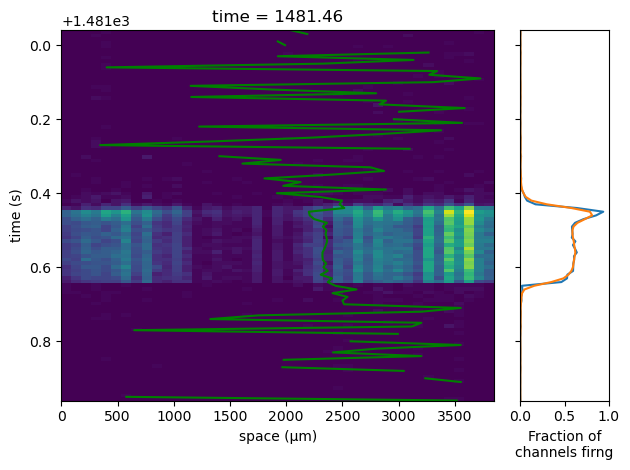

-286.87827167065916
building xt plot


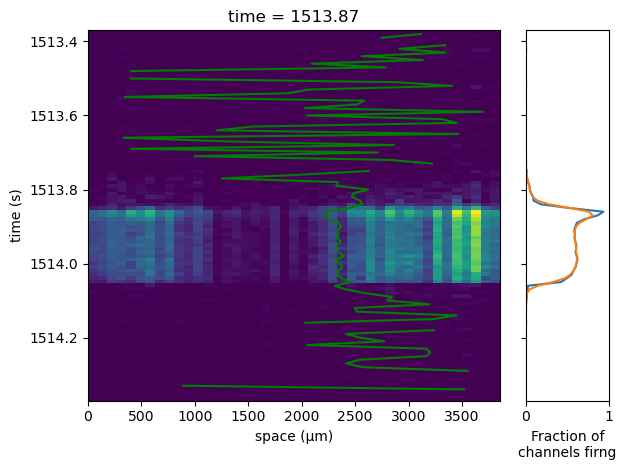

-327.7750906180863
building xt plot


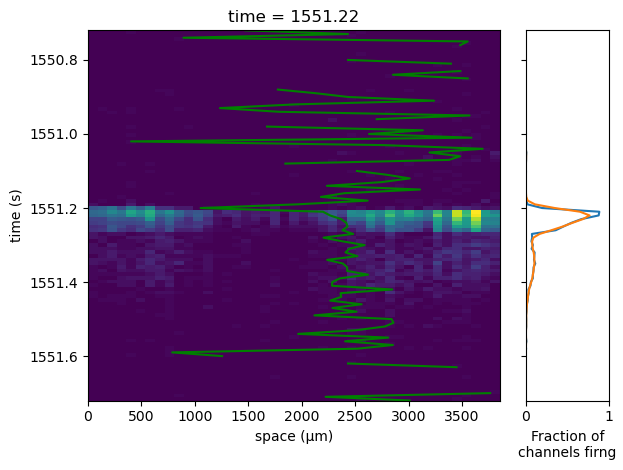

303.50936329588035
building xt plot


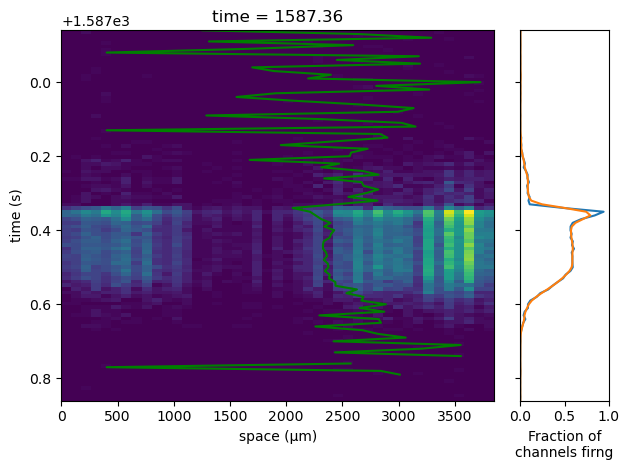

-549.5185296174204
building xt plot


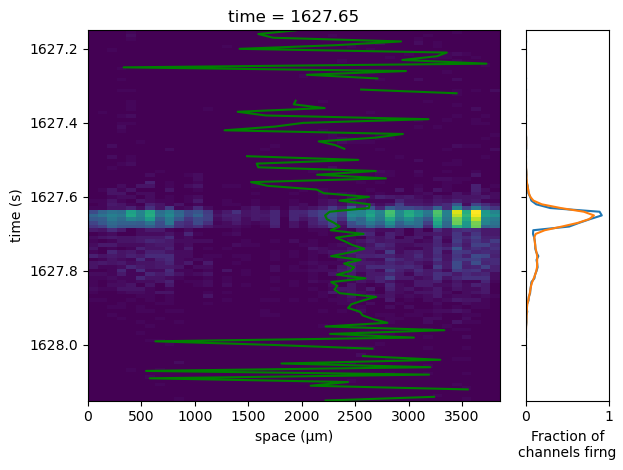

-418.5975629973477
building xt plot


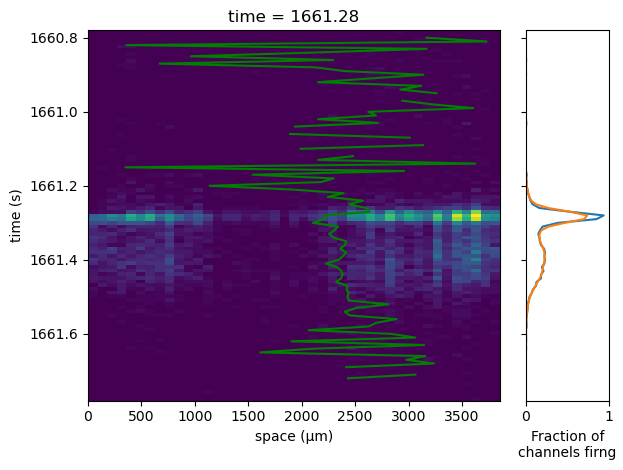

-226.0832763337894
building xt plot


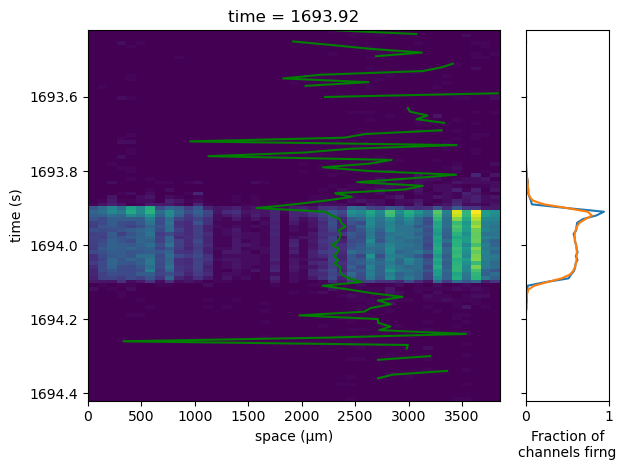

350.1979782887113
building xt plot


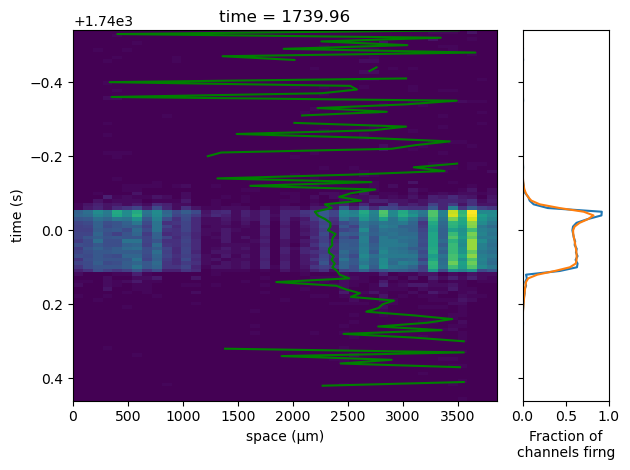

-393.962776673035
building xt plot


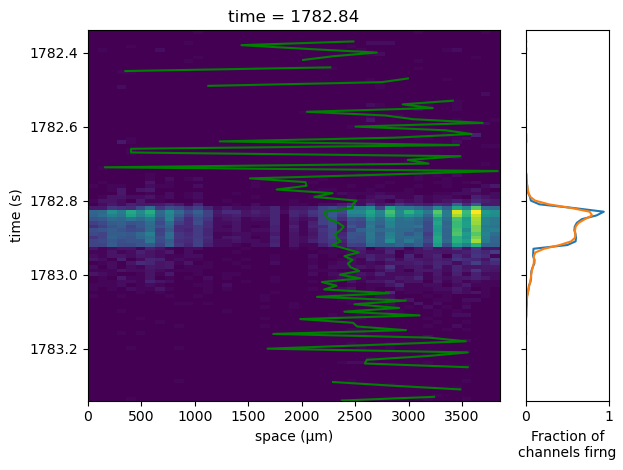

-291.1400462962961
building xt plot


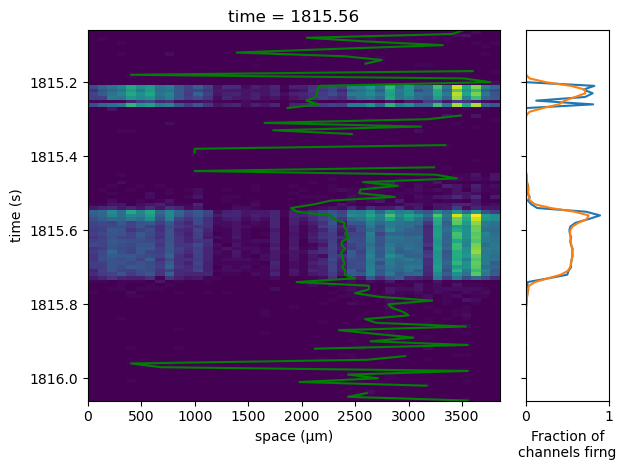

150.3770672546857
building xt plot


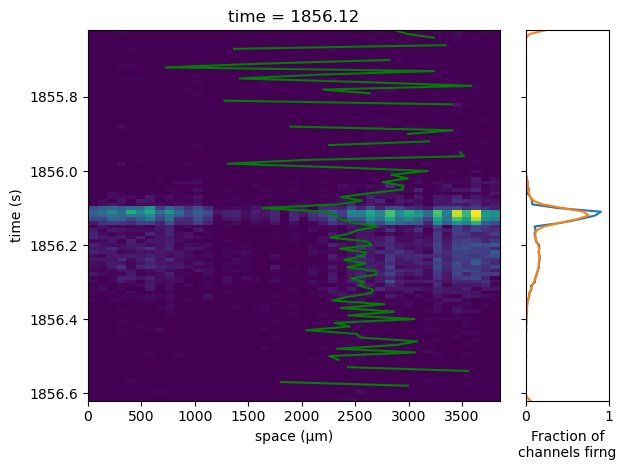

-27.890196078431018
building xt plot


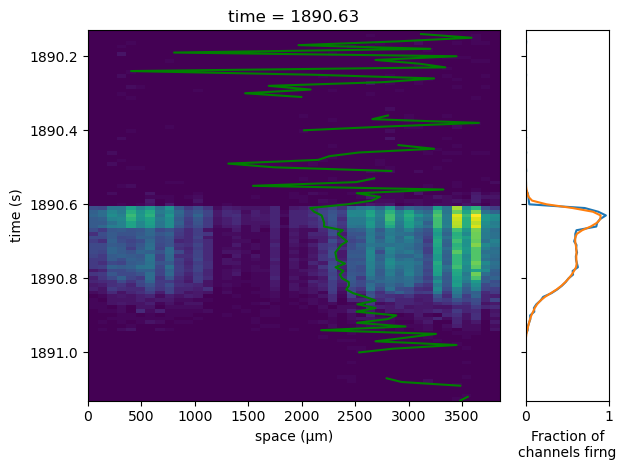

-239.3336741649623
building xt plot


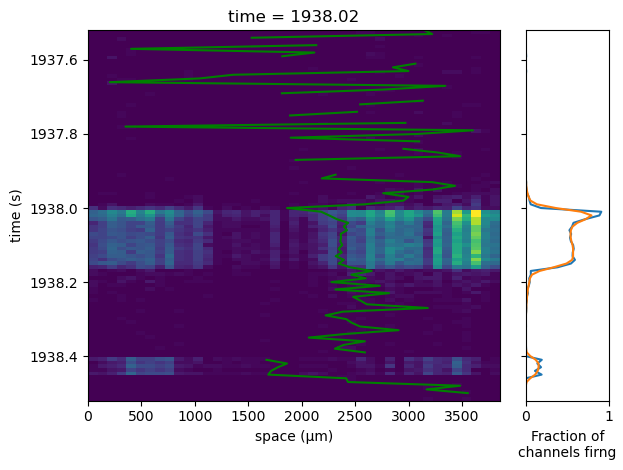

-330.183537263626
building xt plot


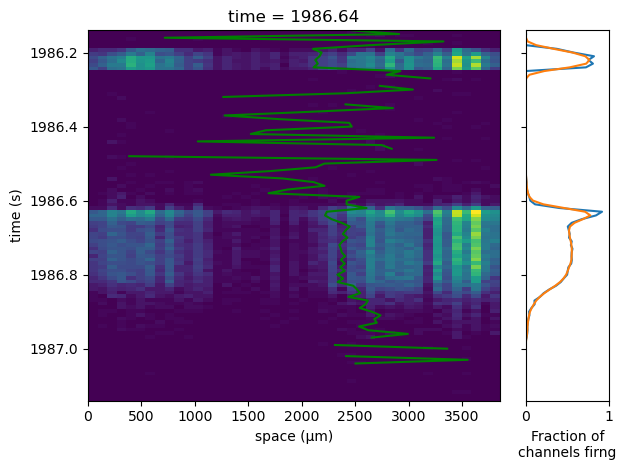

-202.48576936735844
building xt plot


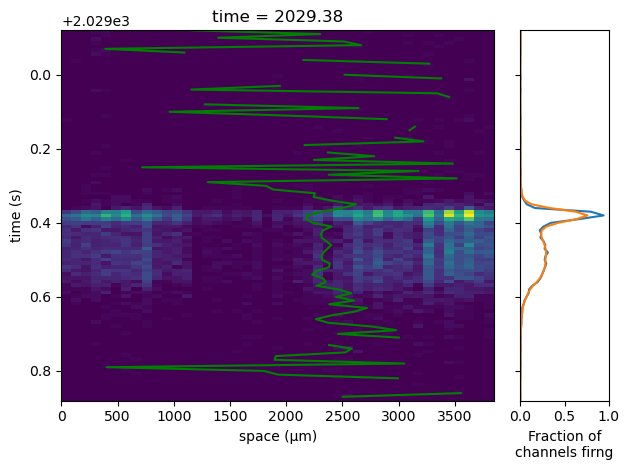

-434.40314136125653
building xt plot


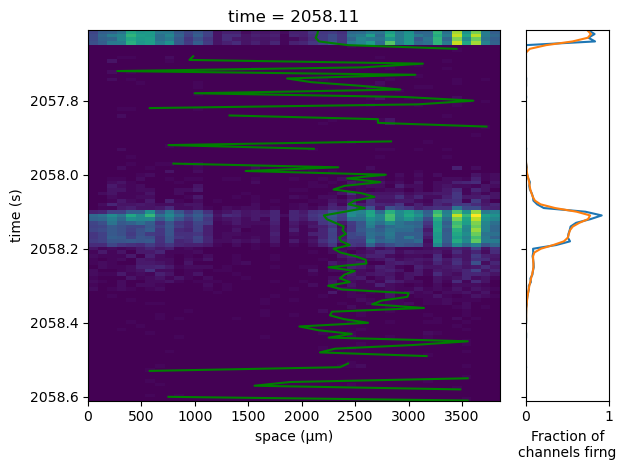

-286.3919264179867
building xt plot


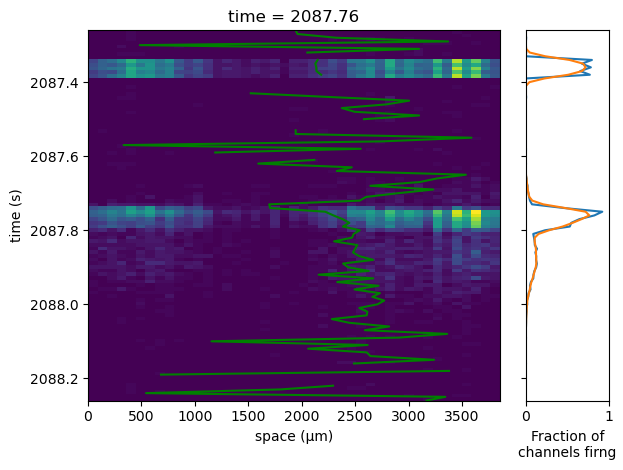

601.1212204760591
building xt plot


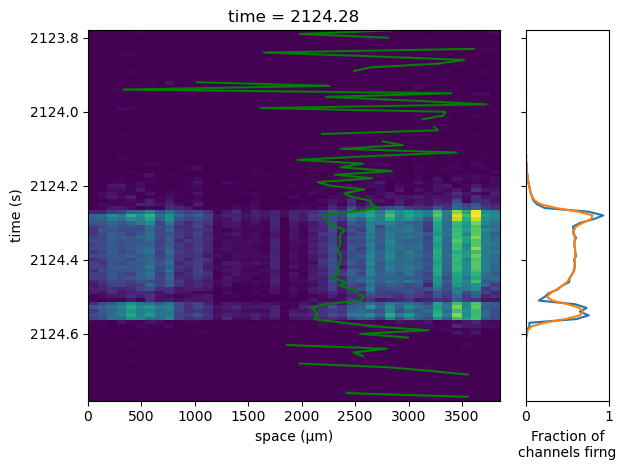

-432.17345634413414
building xt plot


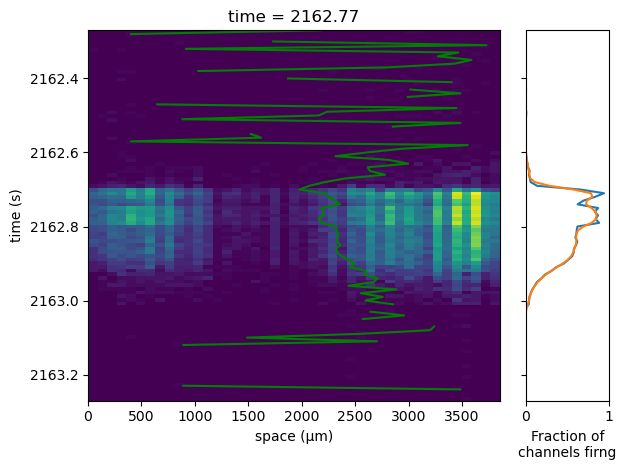

-12.564004096262124
building xt plot


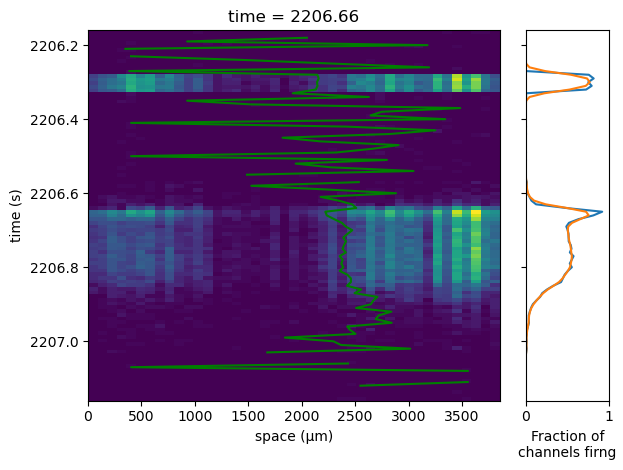

-109.60353138246955
building xt plot


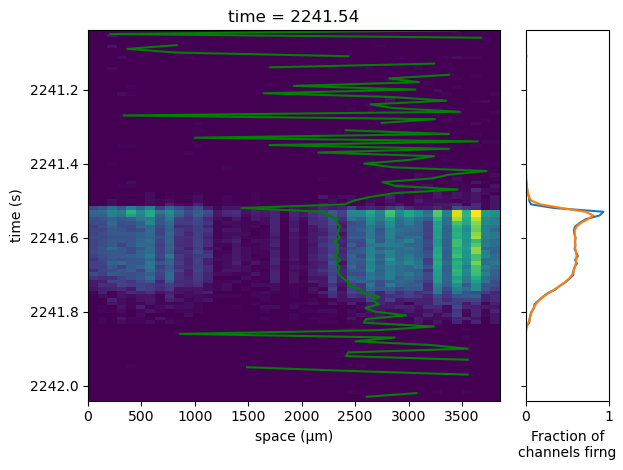

-156.06976744186068
building xt plot


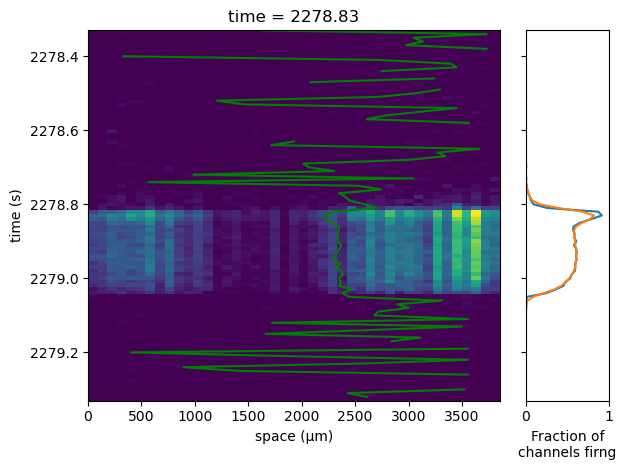

-388.6000909968593
building xt plot


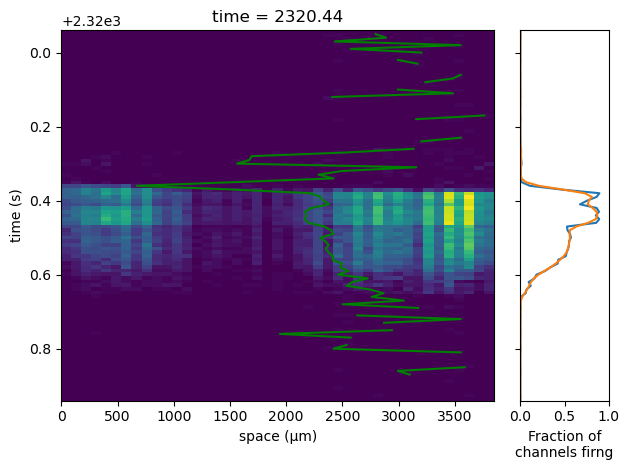

1511.0454545454545
building xt plot


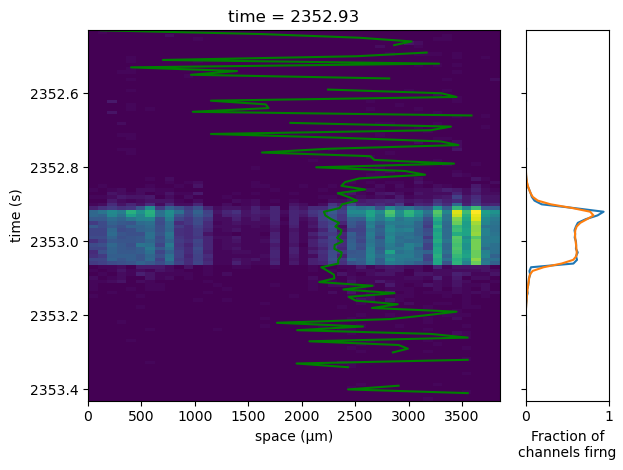

-295.9329020801624
building xt plot


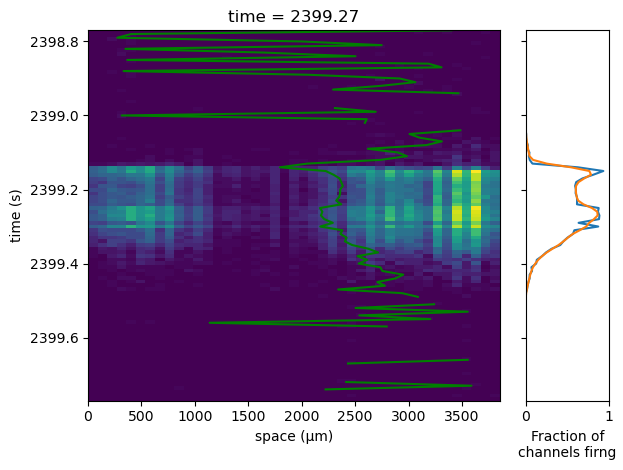

128.41182304300628
building xt plot


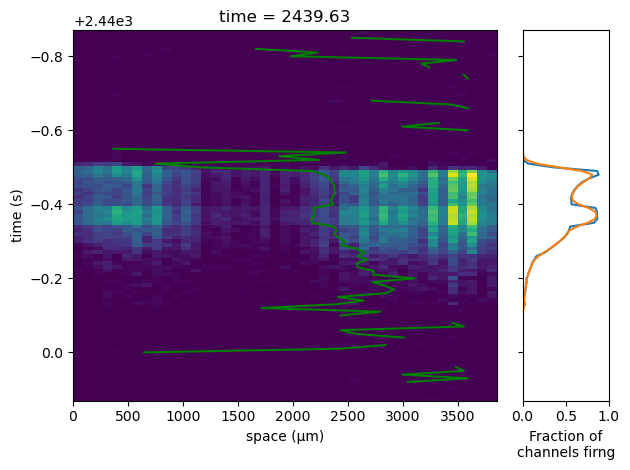

1444.322328184928
building xt plot


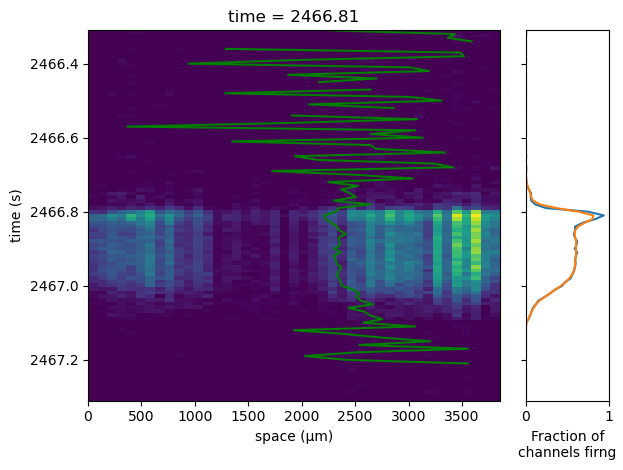

-433.29234279918865
building xt plot


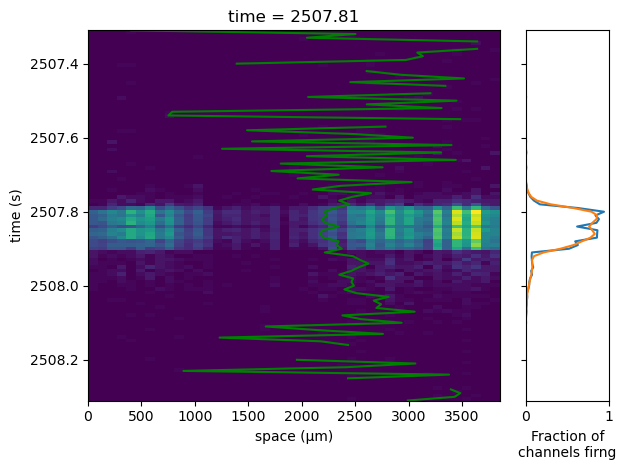

-111.86677726319658
building xt plot


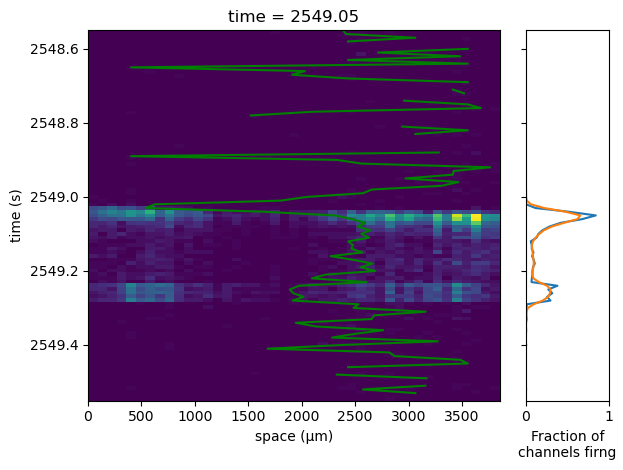

1771.312134502924
building xt plot


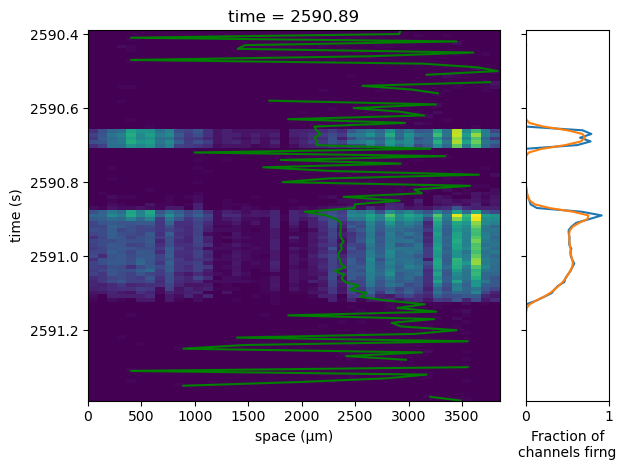

-265.5204962243797
building xt plot


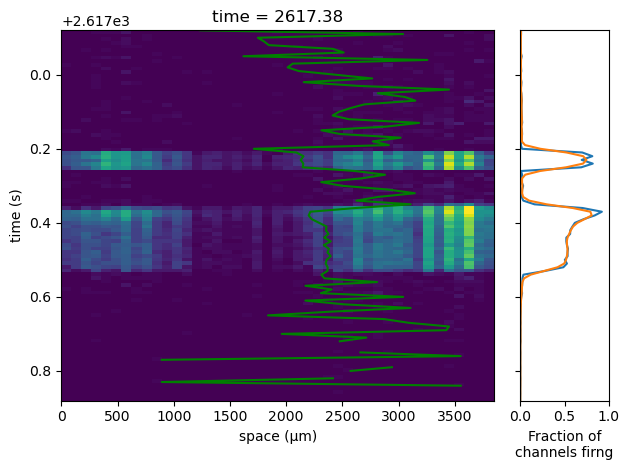

-907.0828292865576
building xt plot


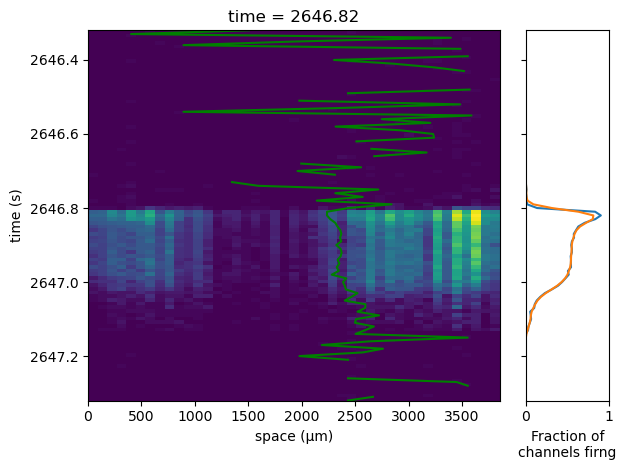

-200.52947598253286
building xt plot


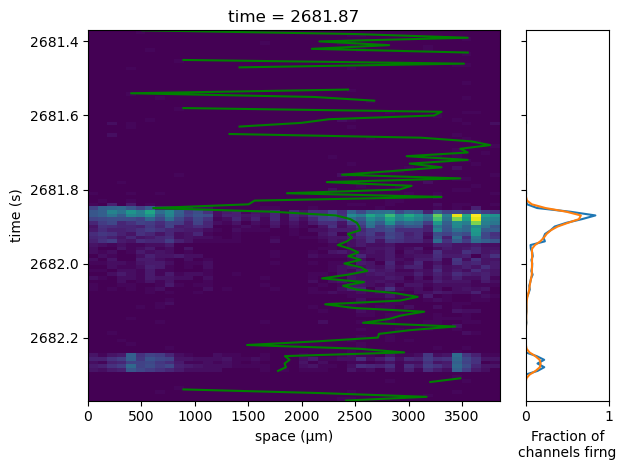

1710.0500000000002
building xt plot


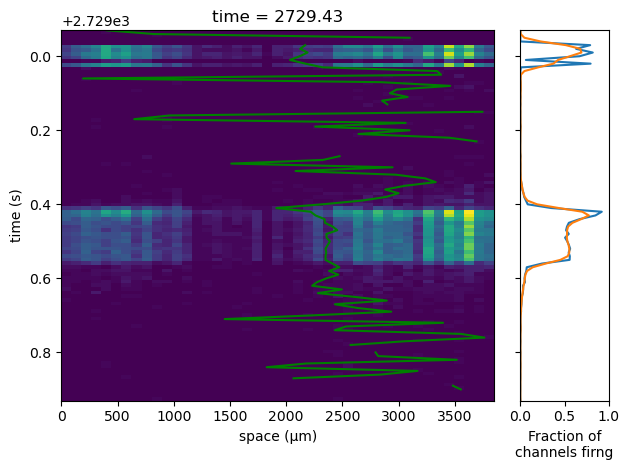

-60.6422764227641
building xt plot


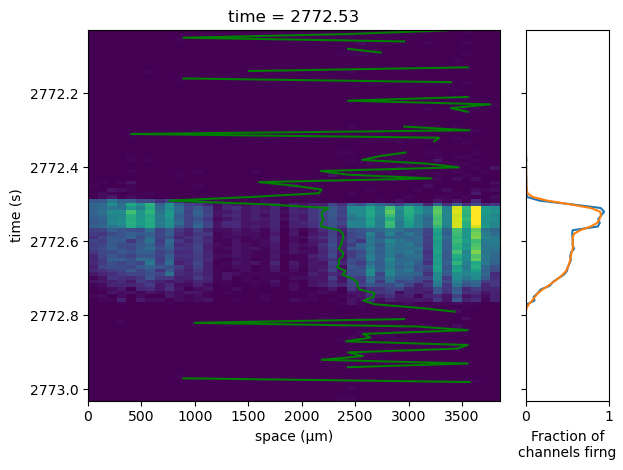

1424.6684782608695
building xt plot


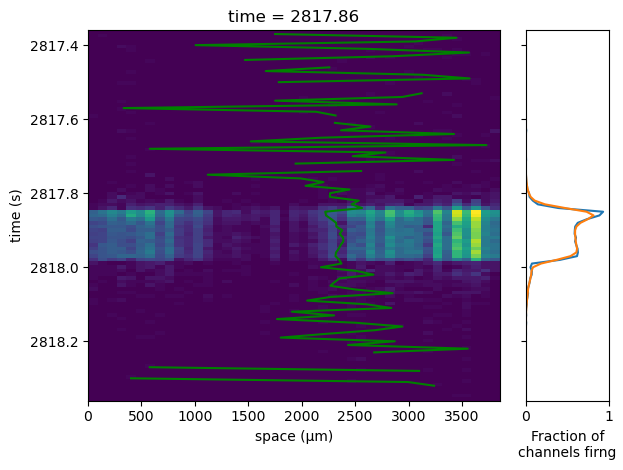

-305.46914500960656
building xt plot


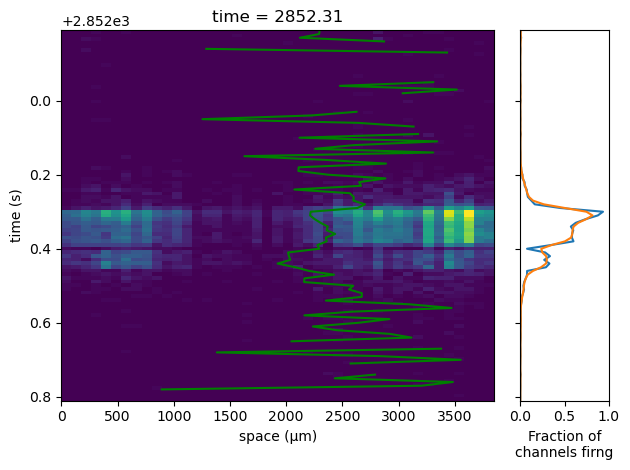

-385.3662126693621
building xt plot


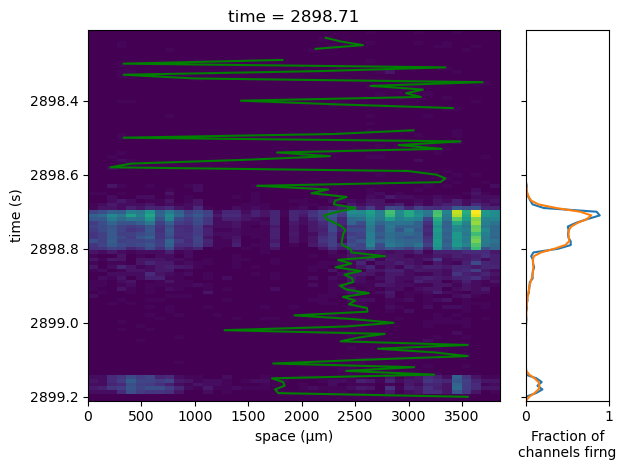

-91.11434108527146
building xt plot


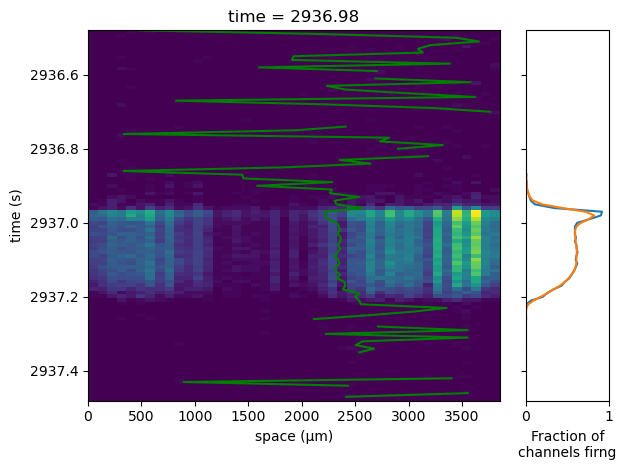

-107.32250219550133
building xt plot


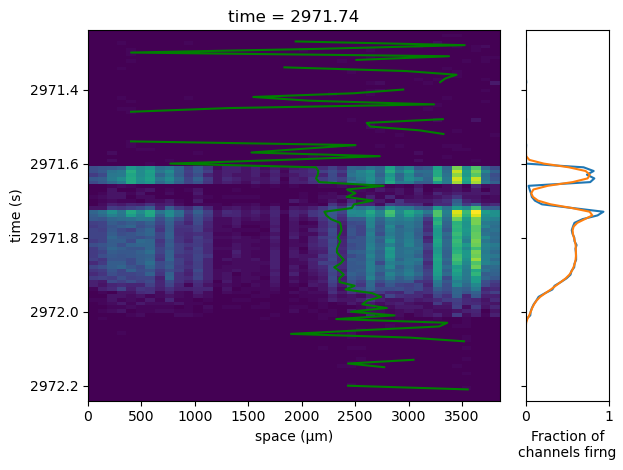

-432.49156463409736
building xt plot


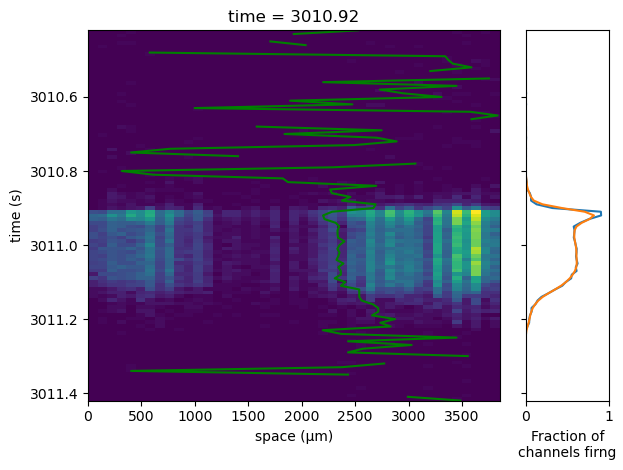

-491.30937702790425
building xt plot


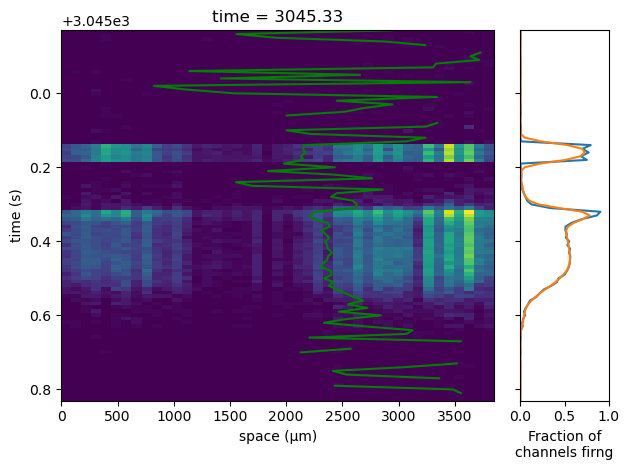

-414.7304479878512
building xt plot


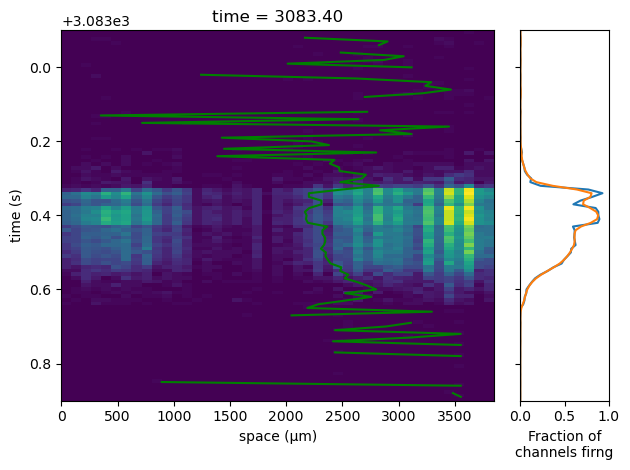

-491.94058165548086
building xt plot


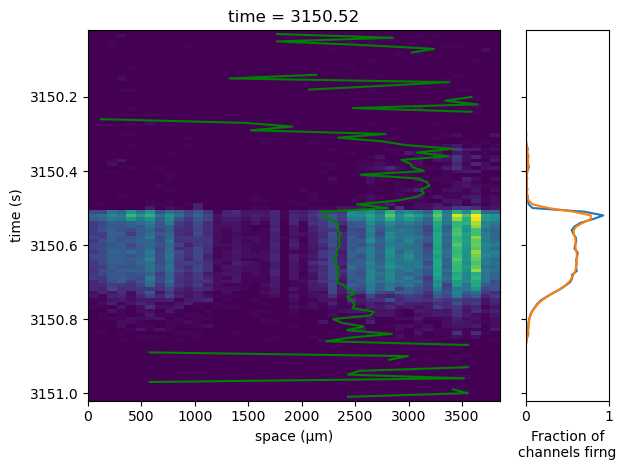

-597.5017599436819
building xt plot


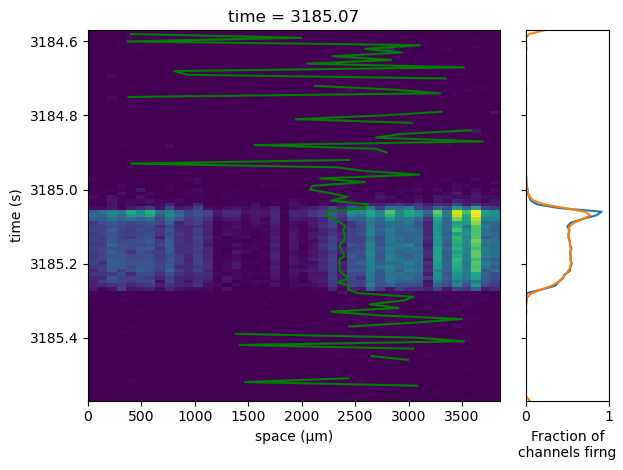

-390.1562367073316
building xt plot


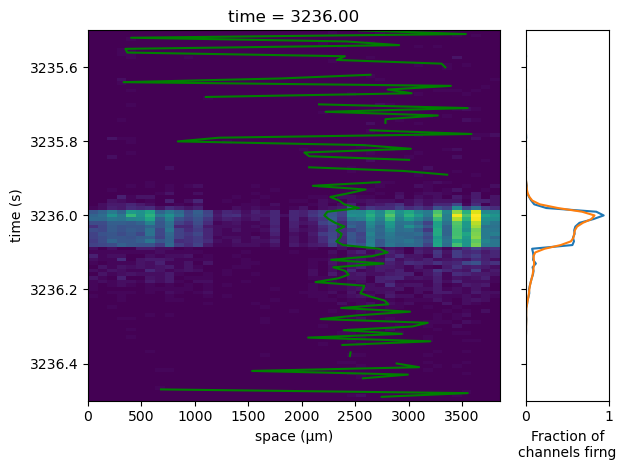

-185.29652996845425
building xt plot


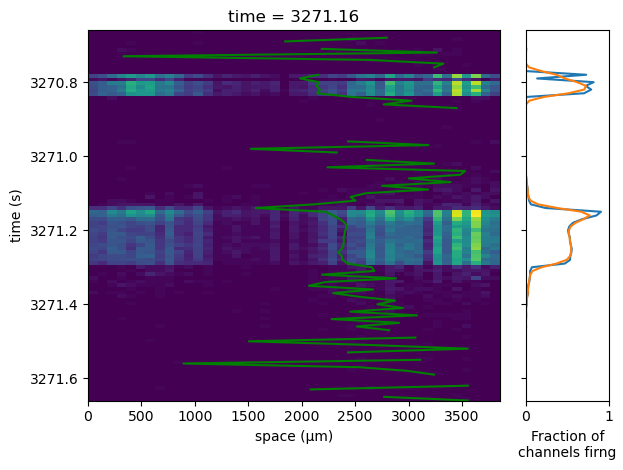

175.93171296296305
building xt plot


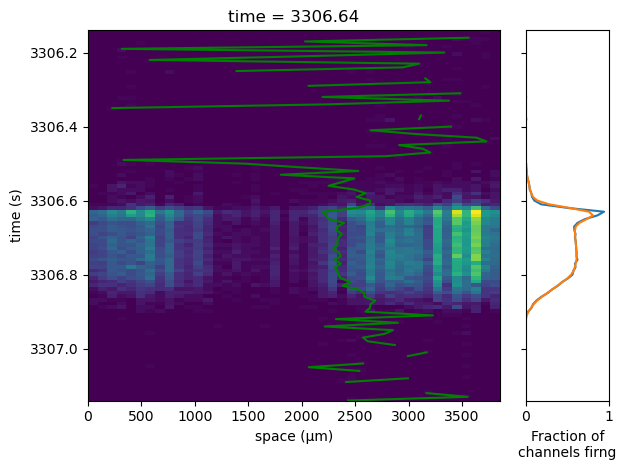

-415.50140079984567
building xt plot


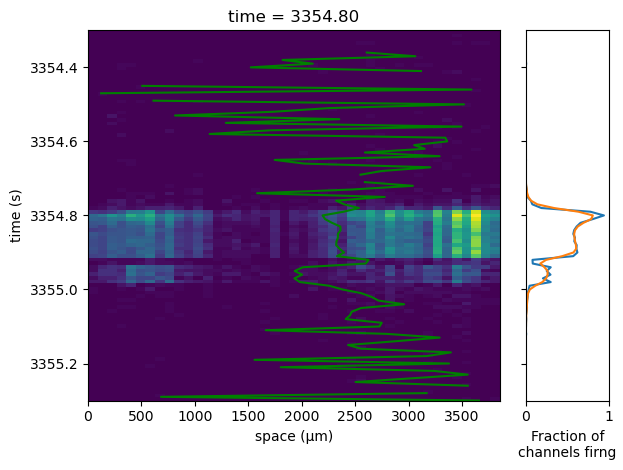

-201.91887815104565
building xt plot


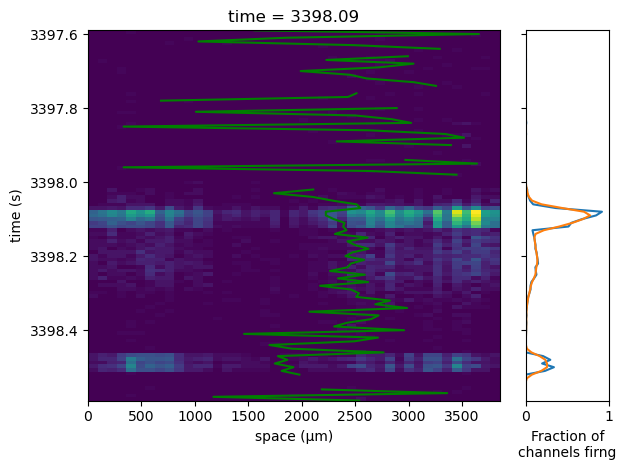

-287.5253369818588
building xt plot


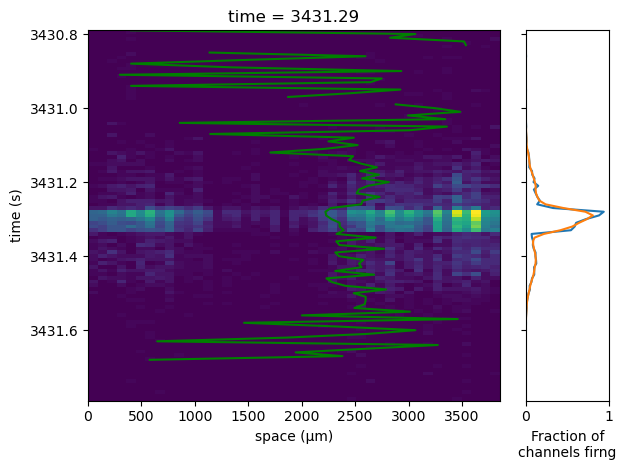

-585.9107682372746
building xt plot


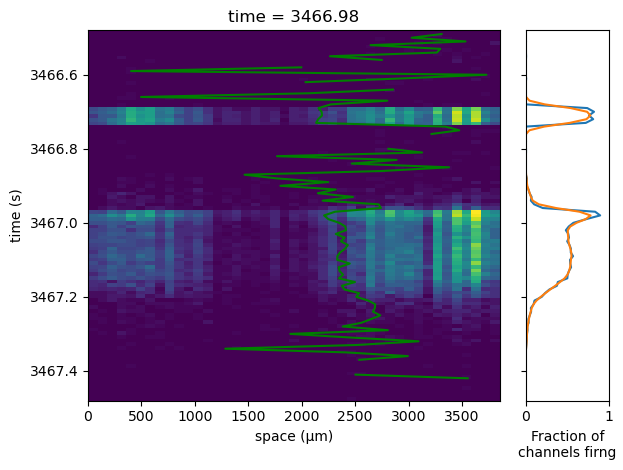

-510.5688749576411
building xt plot


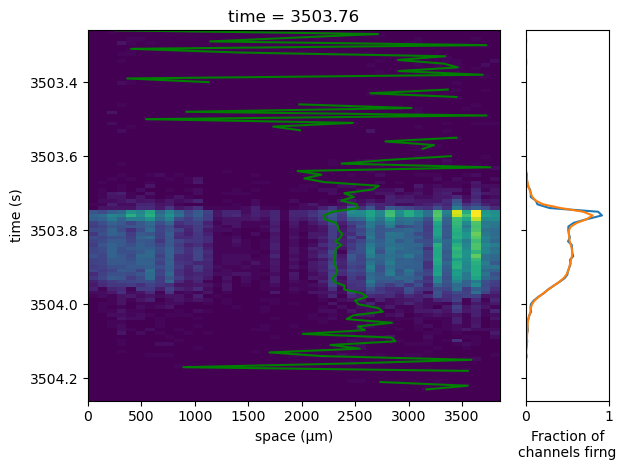

-164.8387096774195
building xt plot


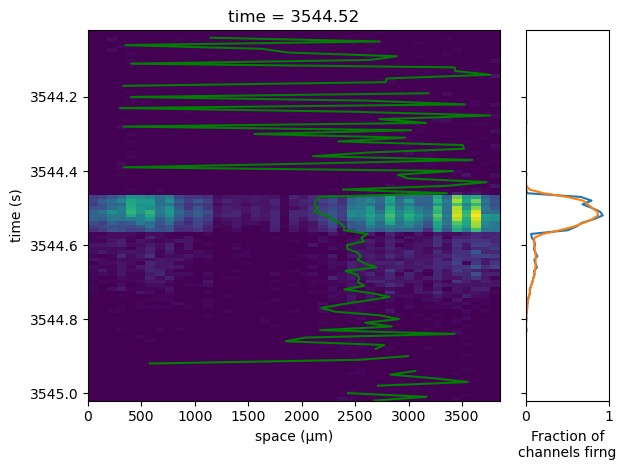

-1121.6404881101375
building xt plot


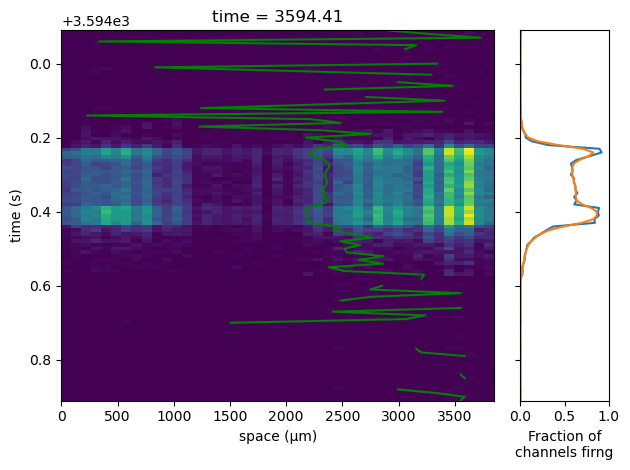

-250.3290555011372


In [238]:
for i in second_trimmed_burst_list:
    i.plot()
    print(i.direction())

In [239]:
def get_position_when_burst(burst: Burst, movement_df: pd.DataFrame)-> int:
    time = burst.time

    position = 0
    

    for i in movement_df.index:
        previous_position = position

        transition_time = movement_df.loc[i, "time"]
        position = movement_df.loc[i, "position"]

        if time < transition_time:
            return previous_position
    

    return position
    

3
1
2
1
2
1
2
3
2
1
0
3
2
1
3
0
3
1
3
2
0
3
2
1
0
3
0
2
2
3
1
3
2
1
0
1
2
1
0
2
2
0
3
2
1
2
3
0
3
2
1
2
3
0
0
3
0
2
3
0
2
3
2
3
0
1
2
3
0
2
1
0
3
0
2
3
0
3
0
3
0
2
3
0
3
0
2
3


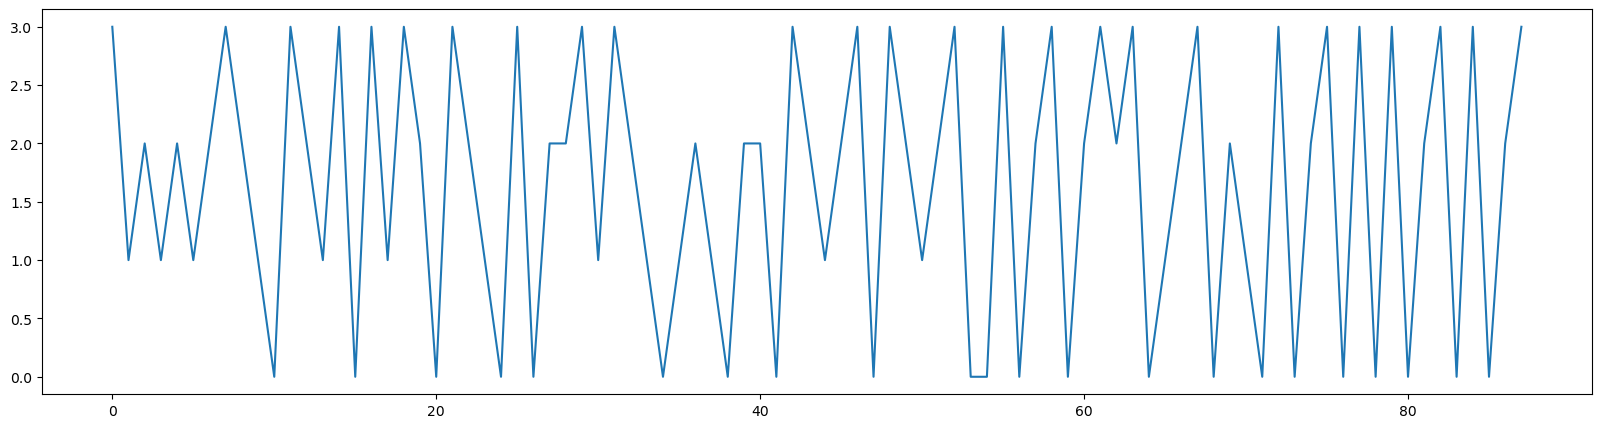

In [240]:
for burst in second_trimmed_burst_list:
    print(get_position_when_burst(burst, full_movement_df))

plt.figure(figsize = (20, 5))
plt.plot([get_position_when_burst(i, full_movement_df) for i in second_trimmed_burst_list])

In [241]:
raw_data_transition_df = pd.DataFrame(columns = ["leftward", "rightward", "total", "proportion left", "object"], index = range(0, len(world)))
pre_train_raw_data_transition_df = pd.DataFrame(columns = ["leftward", "rightward", "total", "proportion left", "object"], index = range(0, len(world)))
train_raw_data_transition_df = pd.DataFrame(columns = ["leftward", "rightward", "total", "proportion left", "object"], index = range(0, len(world)))
raw_data_transition_df["leftward"] = 0
raw_data_transition_df["rightward"] = 0
train_raw_data_transition_df["leftward"] = 0
train_raw_data_transition_df["rightward"] = 0
pre_train_raw_data_transition_df["leftward"] = 0
pre_train_raw_data_transition_df["rightward"] = 0


raw_data_transition_df["object"] = list(world)
train_raw_data_transition_df["object"] = list(world)
pre_train_raw_data_transition_df["object"] = list(world)

display(train_raw_data_transition_df)
display(raw_data_transition_df)
for burst in second_trimmed_burst_list:
    burst_direction = burst.direction()
    position = get_position_when_burst(burst, full_movement_df)
    if burst_direction < 0:
        raw_data_transition_df.loc[position, "leftward"] += 1
        if burst.time < train_time:
            pre_train_raw_data_transition_df.loc[position, "leftward"] += 1
        else:
            train_raw_data_transition_df.loc[position, "leftward"] += 1
    else:
        raw_data_transition_df.loc[position, "rightward"] += 1
        if burst.time < train_time:
            pre_train_raw_data_transition_df.loc[position, "rightward"] += 1
        else:
            train_raw_data_transition_df.loc[position, "rightward"] += 1
    
raw_data_transition_df["total"] = raw_data_transition_df["leftward"] + raw_data_transition_df["rightward"] 
raw_data_transition_df["proportion left"] = raw_data_transition_df["leftward"]/raw_data_transition_df["total"]

train_raw_data_transition_df["total"] = train_raw_data_transition_df["leftward"] + train_raw_data_transition_df["rightward"] 
train_raw_data_transition_df["proportion left"] = train_raw_data_transition_df["leftward"]/train_raw_data_transition_df["total"]

pre_train_raw_data_transition_df["total"] = pre_train_raw_data_transition_df["leftward"] + pre_train_raw_data_transition_df["rightward"] 
pre_train_raw_data_transition_df["proportion left"] = pre_train_raw_data_transition_df["leftward"]/pre_train_raw_data_transition_df["total"]

raw_data_transition_df



leftward  rightward total proportion left object
0         0          0   NaN             NaN      1
1         0          0   NaN             NaN      0
2         0          0   NaN             NaN      0
3         0          0   NaN             NaN      0

leftward  rightward total proportion left object
0         0          0   NaN             NaN      1
1         0          0   NaN             NaN      0
2         0          0   NaN             NaN      0
3         0          0   NaN             NaN      0

leftward  rightward  total  proportion left object
0        21          1     22         0.954545      1
1        10          5     15         0.666667      0
2        21          4     25         0.840000      0
3        18          8     26         0.692308      0

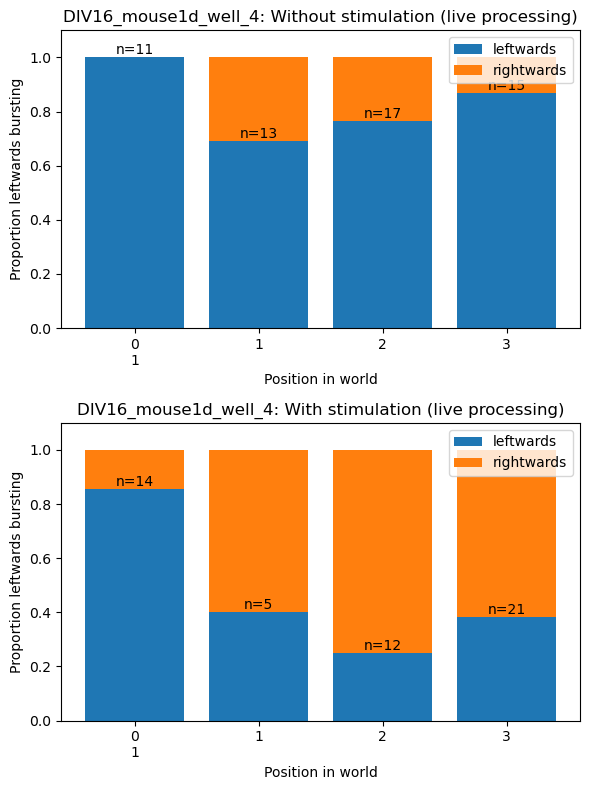

In [242]:
plt.figure(figsize = (6, 8))

ax = plt.subplot(212)
plt.title(filename + ": With stimulation (live processing)")
m1da.make_probability_bars(train_transition_df, world)

ax = plt.subplot(211)
plt.title(filename + ": Without stimulation (live processing)")
m1da.make_probability_bars(pre_train_transition_df, world)

plt.tight_layout()

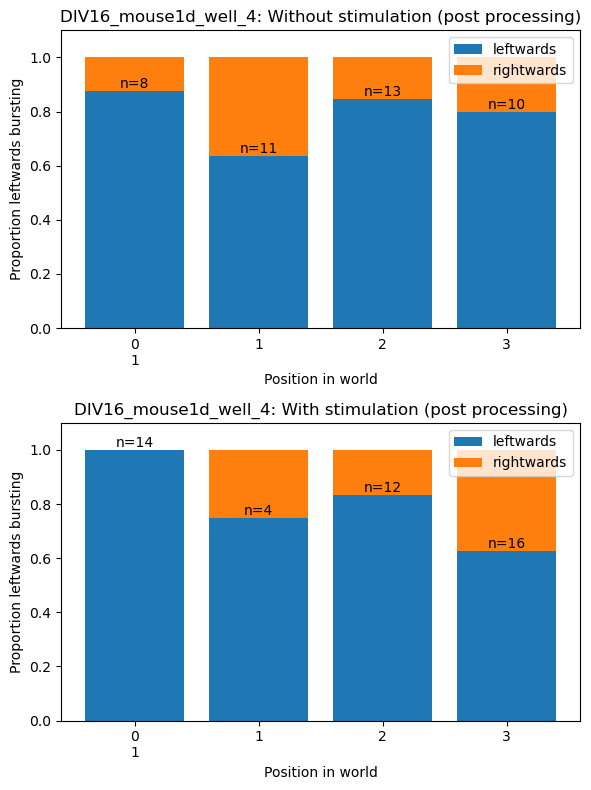

In [243]:
plt.figure(figsize = (6, 8))
plt.subplot(211)
plt.title(filename + ": Without stimulation (post processing)")
m1da.make_probability_bars(pre_train_raw_data_transition_df, world)

plt.subplot(212)
plt.title(filename + ": With stimulation (post processing)")
m1da.make_probability_bars(train_raw_data_transition_df, world)

plt.tight_layout()
